# **About**
In this notebook, I document my journey in a Kaggle competition, focusing on improving model performance for predicting insurance premiums. The dataset consists of three parts: train, test, and original dataset.

### **Goal:**
Predict insurance premium amounts, with **Root Mean Squared Log Error (RMSLE)** as the evaluation metric.

### **Approach:**
**Exploratory Data Analysis (EDA):** Conducted a detailed analysis to understand data distribution, detect outliers, and assess feature relationships.

**Handling Missing Values:** Addressed extreme missing data. Given the dataset size (1.4M observations), I opted for computationally efficient methods, such as imputing missing values using the group-wise median.

**Feature Engineering & Selection:** Created new features, four of which ranked in the top 10 for both gain and split importance. Removed low-importance features to improve model efficiency.

**Target Variable Transformation:** Applied log transformation to **`premium_amount`** to address its heavily right-skewed distribution and mitigate the impact of outliers, improving the robustness of the RMSLE metric.

**Hyperparameter Tuning:** Used RandomizedSearchCV to efficiently identify optimal parameters for the LightGBM model.

### **Results:**
**Initial Score:** Private leaderboard score of **1.15912**

**Improved Score:** Optimizations reduced the score to **1.07849**, demonstrating the effectiveness of these refinements.

This notebook showcases my iterative process of refining models to enhance predictive accuracy.

In [1]:
# Import Library 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

# Display numbers in standard notation
pd.set_option('display.float_format', '{:.2f}'.format) 

# Display all columns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)  
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Read Train Data & Drop `id` 
train_df = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
train_df.drop('id', axis=1, inplace=True)

# Read Test Data & Drop `id`  
test_df = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

# Read Original Data 
original = pd.read_csv('/kaggle/input/insurance-premium-prediction/Insurance Premium Prediction Dataset.csv')

In [3]:
print('Original: ', original.shape)
print('Train: ', train_df.shape)
print('Test: ', test_df.shape) 

Original:  (278860, 20)
Train:  (1200000, 20)
Test:  (800000, 20)


In [4]:
train_df.head(5)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.00,Female,10049.00,Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.00
1,39.00,Female,31678.00,Divorced,3.00,Master's,NaN,15.57,Rural,Comprehensive,1.00,12.00,694.00,2.00,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.00
2,23.00,Male,25602.00,Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,1.00,14.00,NaN,3.00,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.00
3,21.00,Male,141855.00,Married,2.00,Bachelor's,NaN,10.94,Rural,Basic,1.00,0.00,367.00,1.00,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.00
4,21.00,Male,39651.00,Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.00


# **Data Cleaning**

In [5]:
# Change column names to lower_case & replace space with underscore
train_df.columns = train_df.columns.str.replace(' ', '_').str.lower()
test_df.columns = test_df.columns.str.replace(' ', '_').str.lower()
original.columns = original.columns.str.replace(' ', '_').str.lower()

print('Original:\n', original.columns)
print('Train:\n', train_df.columns)
print('Test:\n', test_df.columns)

Original:
 Index(['age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location', 'policy_type', 'previous_claims', 'vehicle_age',
       'credit_score', 'insurance_duration', 'premium_amount',
       'policy_start_date', 'customer_feedback', 'smoking_status',
       'exercise_frequency', 'property_type'],
      dtype='object')
Train:
 Index(['age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location', 'policy_type', 'previous_claims', 'vehicle_age',
       'credit_score', 'insurance_duration', 'policy_start_date',
       'customer_feedback', 'smoking_status', 'exercise_frequency',
       'property_type', 'premium_amount'],
      dtype='object')
Test:
 Index(['id', 'age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location'

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   age                   1181295 non-null  float64
 1   gender                1200000 non-null  object 
 2   annual_income         1155051 non-null  float64
 3   marital_status        1181471 non-null  object 
 4   number_of_dependents  1090328 non-null  float64
 5   education_level       1200000 non-null  object 
 6   occupation            841925 non-null   object 
 7   health_score          1125924 non-null  float64
 8   location              1200000 non-null  object 
 9   policy_type           1200000 non-null  object 
 10  previous_claims       835971 non-null   float64
 11  vehicle_age           1199994 non-null  float64
 12  credit_score          1062118 non-null  float64
 13  insurance_duration    1199999 non-null  float64
 14  policy_start_date     1200000 non-

In [7]:
# Change Data type for `policy_start_date` in all three dataset
original['policy_start_date'] = pd.to_datetime(original['policy_start_date'])
train_df['policy_start_date'] = pd.to_datetime(train_df['policy_start_date'])
test_df['policy_start_date'] = pd.to_datetime(test_df['policy_start_date'])

As per the instructions, we can utilize the original dataset for training. Therefore, we will concatenate the original dataset with the training dataset. Before doing so, we need to verify a few key aspects to ensure consistency:

**Consistency in Columns:** Ensure both datasets have the same number of columns.

**Column Names and Data Types:** Confirm that column names and their data types match in both datasets.

**Categorical Variables:** There are several categorical variables, so we must verify that they have the same number of unique categories to maintain consistency. 

In [8]:
# Define function to check for missing columns
def check_missing_columns(dataset1, dataset2, name_1 = 'dataset1', name_2 = 'dataset2'):
    # Get column names
    dataset1_col = set(dataset1.columns)
    dataset2_col = set(dataset2.columns)
    
    # Find missing columns in each dataset
    missing_col_dataset_1 = dataset2_col - dataset1_col
    missing_col_dataset_2 = dataset1_col - dataset2_col

    # Output the result
    if not missing_col_dataset_1 and not missing_col_dataset_2:
        print(f'Both {name_1} and {name_2} datasets contains the same columns.')
    else:
        if missing_col_dataset_1:
            print(f'Comparing {name_1} & {name_2}: \nThe following columns are missing in {name_1} dataset \n', missing_col_dataset_1)
        if missing_col_dataset_2:
            print(f'Comparing {name_1} & {name_2}: \nThe following columns are missing in {name_2} dataset \n', missing_col_dataset_2)

# Compare both dataset to check for missing columns 
check_missing_columns(original, train_df, name_1 = 'original', name_2 = 'train_df')
print()
check_missing_columns(train_df, test_df, name_1 = 'train_df', name_2 = 'test_df')
print()
check_missing_columns(original, test_df, name_1 = 'original', name_2 = 'test_df')

Both original and train_df datasets contains the same columns.

Comparing train_df & test_df: 
The following columns are missing in train_df dataset 
 {'id'}
Comparing train_df & test_df: 
The following columns are missing in test_df dataset 
 {'premium_amount'}

Comparing original & test_df: 
The following columns are missing in original dataset 
 {'id'}
Comparing original & test_df: 
The following columns are missing in test_df dataset 
 {'premium_amount'}


As we know, both the original and train_df dataset have the same columns, but they are not ordered in the same way. Therefore, I will reorder the columns in the original dataset to align with the train_df dataset. This step ensures that when concatening the datasets, everything will work smoothly. 

In [9]:
# Reorder columns in original dataset to align with train_df dataset
print(list(original.columns) == list(train_df.columns))
original = original[train_df.columns]
print()
print('After reordering:')
print(list(original.columns) == list(train_df.columns))

False

After reordering:
True


In [10]:
# Compare data types between two dataset 
def compare_data_types(dataset1, dataset2, name_1 = 'dataset1', name_2 = 'dataset2'):
    """
    This function checks if the data types of common columns between two DataFrames match
    """
    # Both datasets have the same columns for comparison
    common_columns = dataset1.columns.intersection(dataset2.columns)
    dataset1 = dataset1[common_columns]
    dataset2 = dataset2[common_columns]
    
    # Extract data types for both DataFrames
    dtypes1 = dataset1.dtypes
    dtypes2 = dataset2.dtypes

    # Create DataFrame for comparing data types
    dtype_comparison = pd.DataFrame({f'{name_1}': dtypes1, f'{name_2}': dtypes2})

    # Compare data type: Identify columns with different data types
    dtype_mismatch = dtype_comparison[dtype_comparison[f'{name_1}'] != dtype_comparison[f'{name_2}']]

    # Compare data types between two datasets
    if dtype_mismatch.empty:
        print(f'Comparing between {name_1} & {name_2}: \nAll common columns have matching data types between {name_1} and {name_2}')
    else:
        print(f'Columns with differing data types between {name_1} and {name_2}: \n', dtype_mismatch)

compare_data_types(original, train_df, name_1 = 'original', name_2 = 'train_df')
print()
compare_data_types(train_df, test_df, name_1 = 'train_df', name_2 = 'test_df')
print()
compare_data_types(original, test_df, name_1 = 'original', name_2 = 'test_df') 

Columns with differing data types between original and train_df: 
                    original train_df
vehicle_age           int64  float64
insurance_duration    int64  float64

Comparing between train_df & test_df: 
All common columns have matching data types between train_df and test_df

Columns with differing data types between original and test_df: 
                    original  test_df
vehicle_age           int64  float64
insurance_duration    int64  float64


In [11]:
# Convert data types in original dataset 
original['insurance_duration'] = original['insurance_duration'].astype('float64')
original['vehicle_age'] = original['vehicle_age'].astype('float64')

compare_data_types(original, train_df, name_1 = 'original', name_2 = 'train_df')
print()
compare_data_types(original, test_df, name_1 = 'original', name_2 = 'test_df') 

Comparing between original & train_df: 
All common columns have matching data types between original and train_df

Comparing between original & test_df: 
All common columns have matching data types between original and test_df


In [12]:
# Check for duplicates in each dataset
print('Original:', original.duplicated().sum())
print('Train:', train_df.duplicated().sum())
print('Test:', test_df.duplicated().sum())

Original: 0
Train: 0
Test: 0


In [13]:
# Check for infinite values in the `premium_amount` column
train_df['premium_amount'].isin([np.inf, -np.inf]).any()

False

In [14]:
# Extract all catgorical variables
categorical = train_df.select_dtypes(include=['object']).columns.tolist()

# Extract all numerical variables
numerical = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical.remove('premium_amount')

In [15]:
# Numerical Features
numerical 

['age',
 'annual_income',
 'number_of_dependents',
 'health_score',
 'previous_claims',
 'vehicle_age',
 'credit_score',
 'insurance_duration']

In [16]:
# Creat dictionary to hold unqiue categories for each categorical varibale
cat_unique = {var: train_df[var].dropna().unique().tolist() for var in categorical}
cat_unique

{'gender': ['Female', 'Male'],
 'marital_status': ['Married', 'Divorced', 'Single'],
 'education_level': ["Bachelor's", "Master's", 'High School', 'PhD'],
 'occupation': ['Self-Employed', 'Employed', 'Unemployed'],
 'location': ['Urban', 'Rural', 'Suburban'],
 'policy_type': ['Premium', 'Comprehensive', 'Basic'],
 'customer_feedback': ['Poor', 'Average', 'Good'],
 'smoking_status': ['No', 'Yes'],
 'exercise_frequency': ['Weekly', 'Monthly', 'Daily', 'Rarely'],
 'property_type': ['House', 'Apartment', 'Condo']}

In [17]:
# Check consistency of unique categories across dataset 
for var in categorical:
    original_unique = set(original[var].dropna().unique())
    train_unique = set(train_df[var].dropna().unique())
    test_unique = set(test_df[var].dropna().unique())

    # Check if the count of unique categories and the categories themselves match 
    if len(original_unique) == len(train_unique) == len(test_unique) and original_unique == train_unique == test_unique:
        print(f'Categories for {var} have same count & matches across all datasets')
    elif len(original_unique) == len(train_unique) == len(test_unique):
        print(f'Categories for {var} have same count but in all datasets but categories do not match excatly')
    else:
        print(f'Number of unique categories for {var} does not match across all datasets')

Categories for gender have same count & matches across all datasets
Categories for marital_status have same count & matches across all datasets
Categories for education_level have same count & matches across all datasets
Categories for occupation have same count & matches across all datasets
Categories for location have same count & matches across all datasets
Categories for policy_type have same count & matches across all datasets
Categories for customer_feedback have same count & matches across all datasets
Categories for smoking_status have same count & matches across all datasets
Categories for exercise_frequency have same count & matches across all datasets
Categories for property_type have same count & matches across all datasets


# **Distribution Analysis of Categorical Variables**

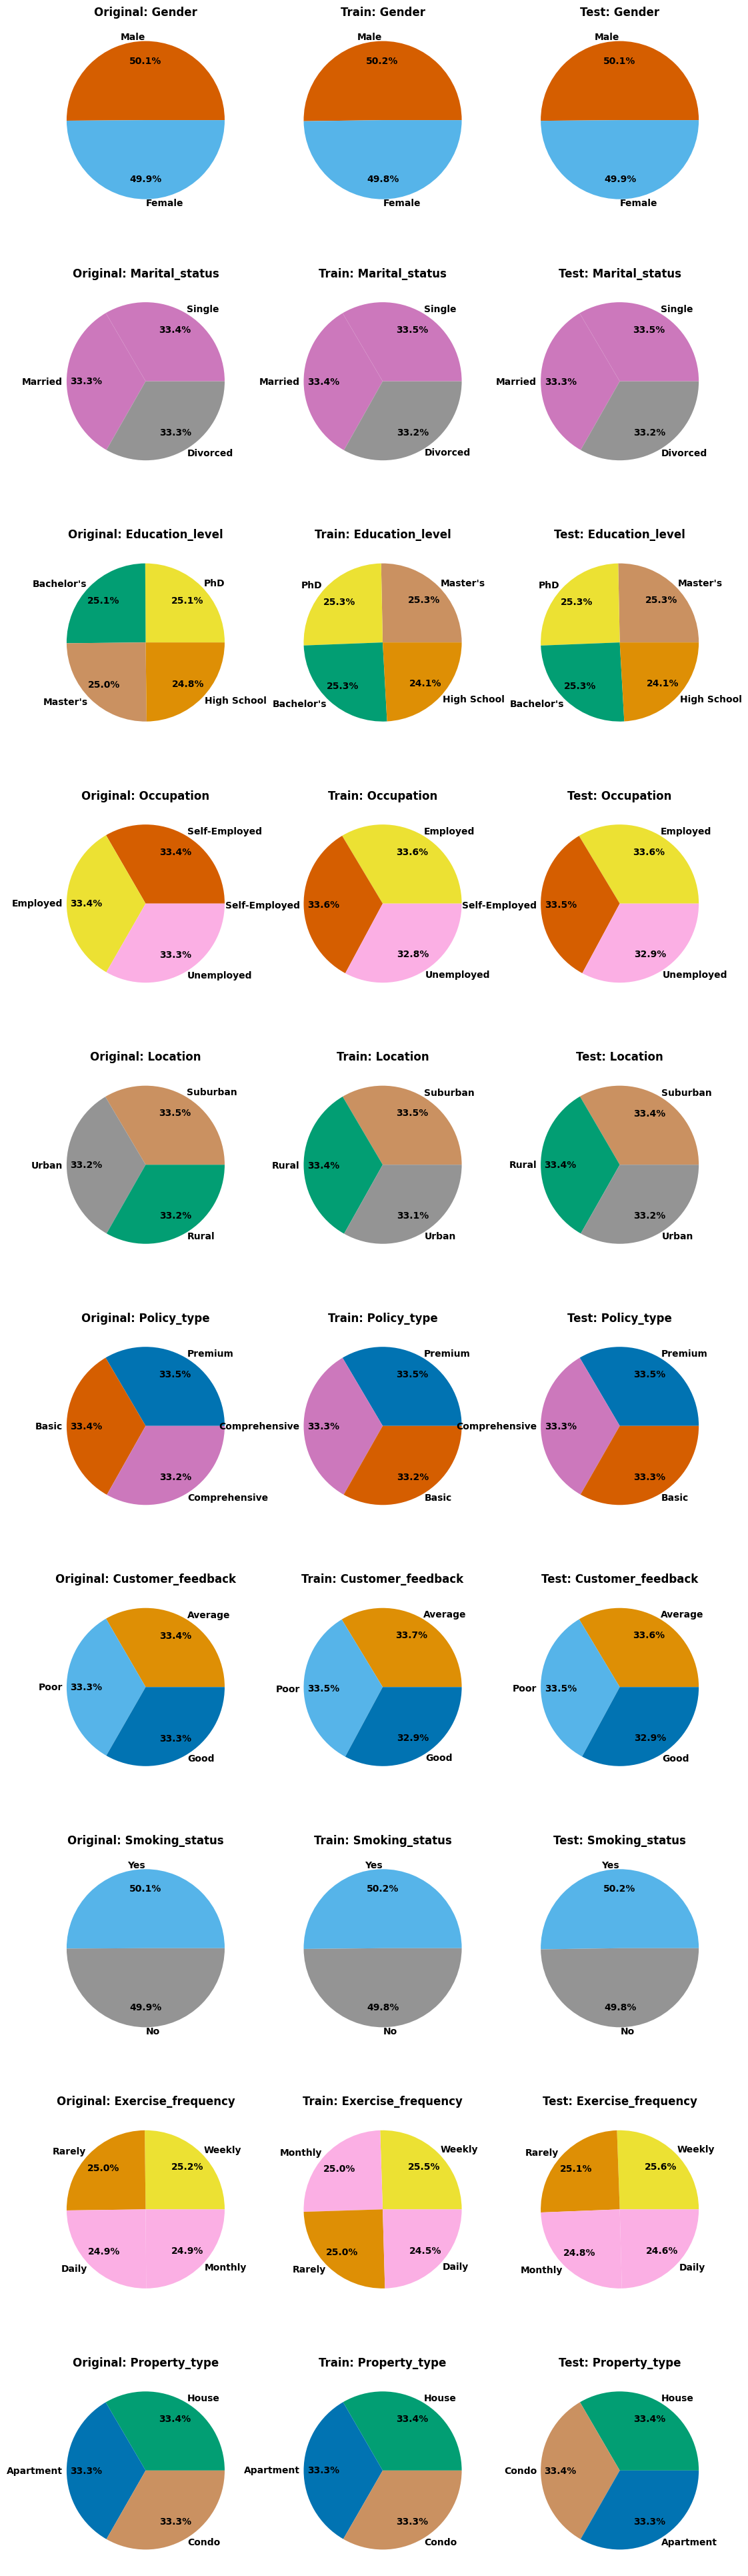

In [18]:
# Setup subplots
fig, axes = plt.subplots(len(categorical), 3, figsize = (13, 5 * len(categorical)))

# Set consistent color_palette
unique_categories = set()
for var in categorical:
    unique_categories.update(original[var].dropna().unique())
    unique_categories.update(train_df[var].dropna().unique())
    unique_categories.update(test_df[var].dropna().unique())

# Create color palette mapping all unique categories
palette = sns.color_palette('colorblind', len(unique_categories))
color_mapping = dict(zip(sorted(unique_categories), palette))
        
# Create subplots
for i, var in enumerate(categorical):
    original_counts = original[var].value_counts()
    train_counts = train_df[var].value_counts()
    test_counts = test_df[var].value_counts()

    # Assign consistent colors
    original_colors = [color_mapping[cat] for cat in original_counts.index]
    train_colors = [color_mapping[cat] for cat in train_counts.index]
    test_colors = [color_mapping[cat] for cat in test_counts.index]

    # Plot pie chart for original
    axes[i, 0].pie(original_counts,
                   labels = original_counts.index,
                   autopct = '%1.1f%%',
                   labeldistance = 1.05,
                   pctdistance = 0.75,
                   textprops = {'fontsize': 10, 'fontweight': 'bold'},
                   colors = original_colors)
    axes[i, 0].set_title(f'Original: {var.capitalize()}', weight = 'bold')

    # Plot pie chart for train_df
    axes[i, 1].pie(train_counts,
                   labels = train_counts.index,
                   autopct = '%1.1f%%',
                   labeldistance = 1.05,
                   pctdistance = 0.75,
                   textprops = {'fontsize': 10, 'fontweight': 'bold'},
                   colors = train_colors)
    axes[i, 1].set_title(f'Train: {var.capitalize()}', weight = 'bold')

    # Plot pie chart for test_df
    axes[i, 2].pie(test_counts,
                   labels = test_counts.index,
                   autopct = '%1.1f%%',
                   labeldistance = 1.05,
                   pctdistance = 0.75,
                   textprops = {'fontsize': 10, 'fontweight': 'bold'},
                   colors = test_colors)
    axes[i, 2].set_title(f'Test: {var.capitalize()}', weight = 'bold')

All categorical variables in the train, test, and original datasets exhibit balanced distributions. For example, the gender variable is nearly evenly split, with **50.1%** male and **49.9%** female. Similarly, other categorical variables also have a fairly even distribution across their unique categories.

# **Distribution Analysis of Numerical Variables**

In this section, we will examine and compare the distribution of numerical vaiables across the original, train, and test datasets. This analysis aims to:
- Ensure consistency in data distribution across the datasets.
- Identify any potential outliers.

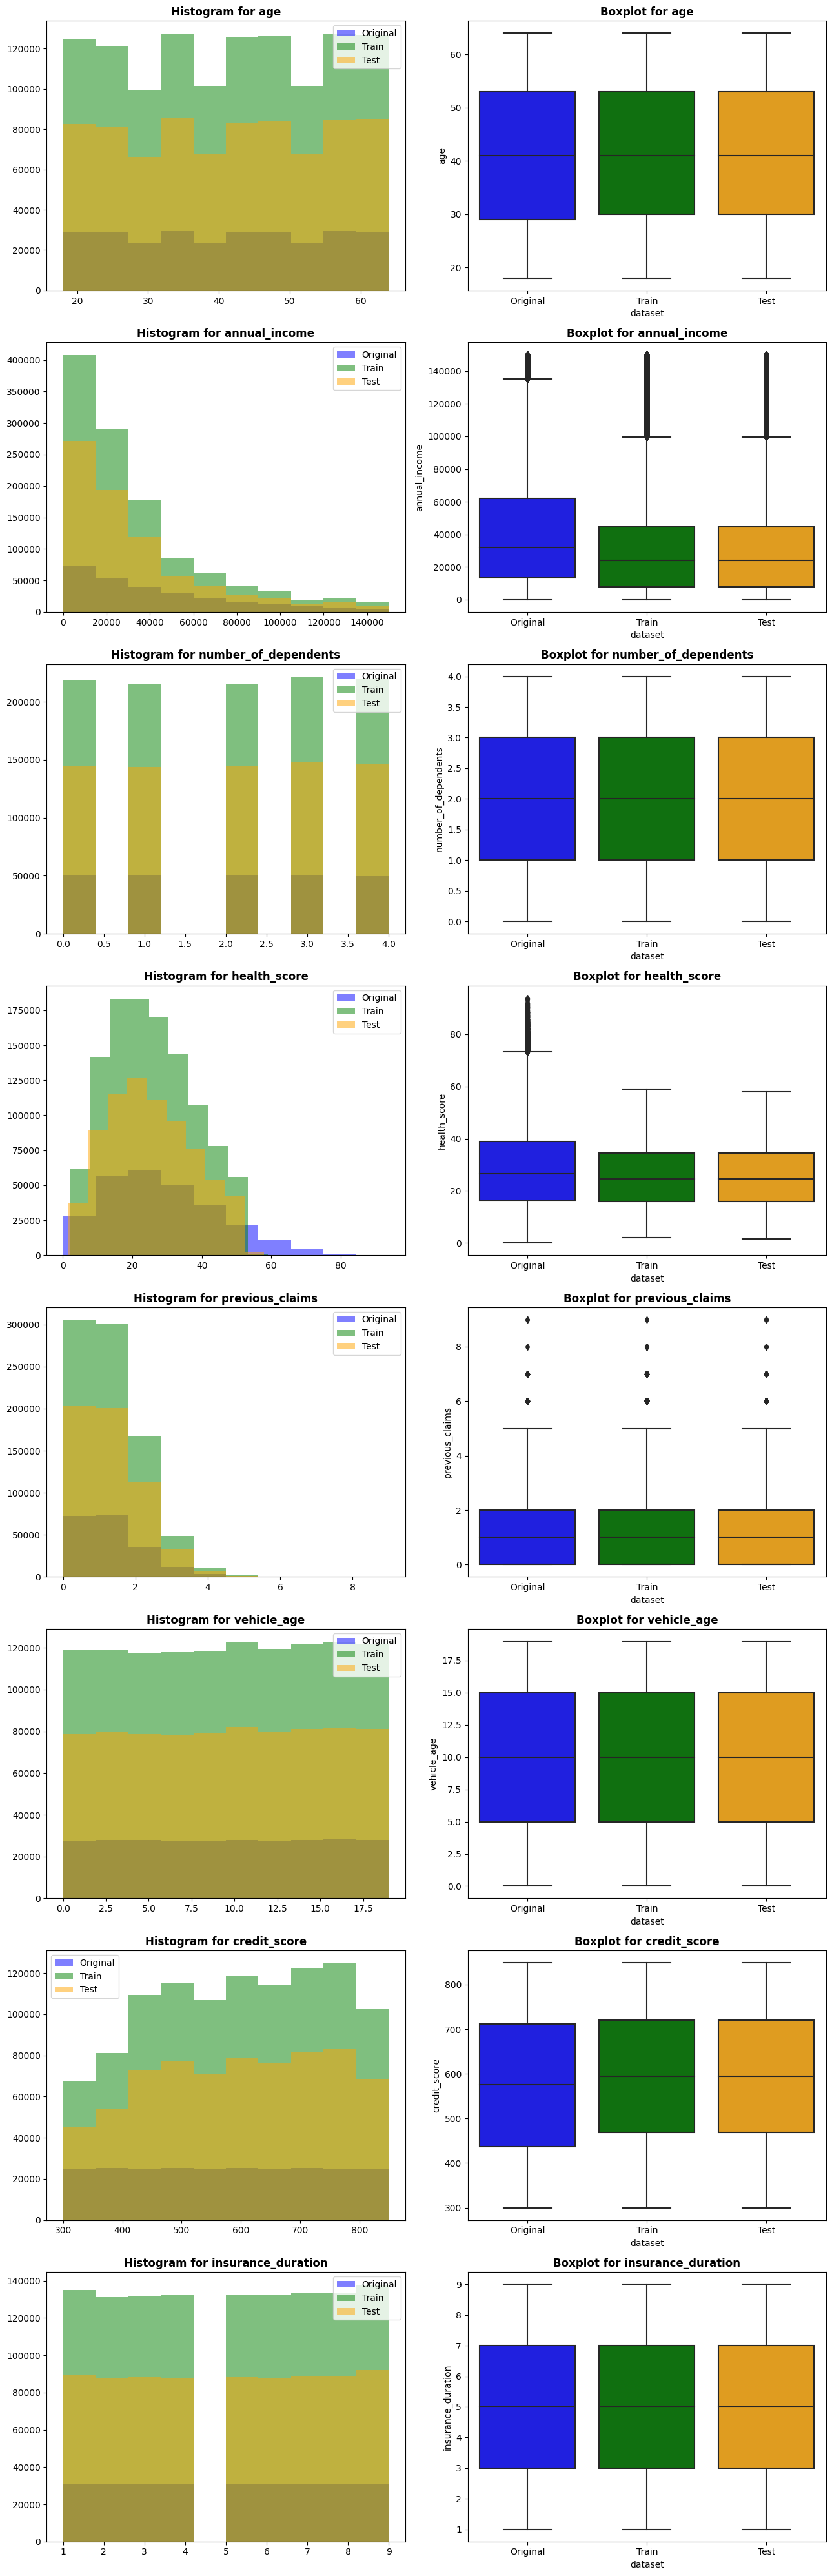

In [19]:
# Setup subplots
fig, axes = plt.subplots(len(numerical), 2, figsize = (13, 5 * len(numerical)))

# Color for datasets
palette = {'Original':'blue', 'Train':'green', 'Test':'orange'}

# Plot Histogram
for i, var in enumerate(numerical):
    axes[i, 0].hist(original[var], alpha=0.5, color=palette['Original'], label='Original')
    axes[i, 0].hist(train_df[var], alpha=0.5, color=palette['Train'], label='Train')
    axes[i, 0].hist(test_df[var], alpha=0.5, color=palette['Test'], label='Test')
    axes[i, 0].set_title(f'Histogram for {var}', weight='bold')
    axes[i, 0].legend()

    # Prepare data for boxplot 
    combined = pd.concat([original[var].to_frame().assign(dataset='Original'),
                         train_df[var].to_frame().assign(dataset='Train'),
                         test_df[var].to_frame().assign(dataset='Test')
                         ])
    # Plot Boxplot
    sns.boxplot(data=combined, x='dataset', y=var, ax=axes[i, 1], palette=palette)
    axes[i, 1].set_title(f'Boxplot for {var}', weight='bold')

plt.tight_layout()
plt.show() 

## **age, insurance_duration, vehicle_age, number_of_dependents**

In [20]:
print('Original Descriptive Stats:') 
print(original[['age', 'insurance_duration', 'vehicle_age', 'number_of_dependents']].describe().T)
print()
print('Train Descriptive Stats:')
print(train_df[['age', 'insurance_duration', 'vehicle_age', 'number_of_dependents']].describe().T)
print()
print('Test Descriptive Stats:')
print(test_df[['age', 'insurance_duration', 'vehicle_age', 'number_of_dependents']].describe().T)

Original Descriptive Stats:
                         count  mean   std   min   25%   50%   75%   max
age                  274175.00 41.02 13.55 18.00 29.00 41.00 53.00 64.00
insurance_duration   278860.00  5.01  2.58  1.00  3.00  5.00  7.00  9.00
vehicle_age          278860.00  9.52  5.77  0.00  5.00 10.00 15.00 19.00
number_of_dependents 250974.00  2.00  1.41  0.00  1.00  2.00  3.00  4.00

Train Descriptive Stats:
                          count  mean   std   min   25%   50%   75%   max
age                  1181295.00 41.15 13.54 18.00 30.00 41.00 53.00 64.00
insurance_duration   1199999.00  5.02  2.59  1.00  3.00  5.00  7.00  9.00
vehicle_age          1199994.00  9.57  5.78  0.00  5.00 10.00 15.00 19.00
number_of_dependents 1090328.00  2.01  1.42  0.00  1.00  2.00  3.00  4.00

Test Descriptive Stats:
                         count  mean   std   min   25%   50%   75%   max
age                  787511.00 41.14 13.54 18.00 30.00 41.00 53.00 64.00
insurance_duration   799998.00  5.02  2.

The shape of the data distribution in the histograms indicates that the distributions for all four variables - **`age`, `insurance_duration`, `vehicle_age`, and `number_of_dependents`** are similar across the three datasets. Boxplots show no outliers for these variables in any of the datasets. 

The descriptive statistics and boxplots suggest that the distributions of these variables are consistent across the three datasets. This consistency is reflected in the approximately similar means, medians, quartiles, minimums, and maximums, as well as the absence of outliers. 

## **credit_score and health_score**

In [21]:
print('Original Descriptive Stats:')
print(original[['credit_score', 'health_score']].describe())
print()
print('Train Descriptive Stats:')
print(train_df[['credit_score', 'health_score']].describe())
print()
print('Test Descriptive Stats:')
print(test_df[['credit_score', 'health_score']].describe())

Original Descriptive Stats:
       credit_score  health_score
count     250974.00     268263.00
mean         574.36         28.58
std          158.79         15.97
min          300.00          0.04
25%          437.00         16.15
50%          575.00         26.45
75%          712.00         38.97
max          849.00         93.88

Train Descriptive Stats:
       credit_score  health_score
count    1062118.00    1125924.00
mean         592.92         25.61
std          149.98         12.20
min          300.00          2.01
25%          468.00         15.92
50%          595.00         24.58
75%          721.00         34.53
max          849.00         58.98

Test Descriptive Stats:
       credit_score  health_score
count     708549.00     750551.00
mean         592.90         25.61
std          150.12         12.21
min          300.00          1.65
25%          468.00         15.92
50%          595.00         24.58
75%          721.00         34.52
max          849.00         57.96


The descriptive statistics for **`credit_score`** and **`health_score`** across the three datasets show similar patterns, with means, medians, quartiles, minimums, and maximums being quite close, though not identical. The boxplots for **`credit_score`** indicate no outliers in any of the datasets. However, the box for the original dataset is slightly larger than those for the train and test datasets, which are of equal size. This suggests that while the overall distribution of **`credit_score`** is consistent, the original dataset has a slightly wider spread of values compared to the train and test datasets. 

For **`health_score`**, the histograms shows that the distribution is quite similar across the three datasets, with a slightly longer tail in the original dataset. The boxplot reveals that there are outliers in the **`health_score`** of the original dataset, while the train and test datasets do not have any outliers. 

## **annual_income and previous_claims**

In [22]:
print('Original Descriptive Stats:') 
print(original[['annual_income', 'previous_claims']].describe())
print()
print('Train Descriptive Stats:')
print(train_df[['annual_income', 'previous_claims']].describe())
print()
print('Test Descriptive Stats:')
print(test_df[['annual_income', 'previous_claims']].describe())

Original Descriptive Stats:
       annual_income  previous_claims
count      264905.00        197572.00
mean        42089.09             1.00
std         35444.52             1.00
min             0.00             0.00
25%         13588.00             0.00
50%         32191.00             1.00
75%         62164.00             2.00
max        149997.00             9.00

Train Descriptive Stats:
       annual_income  previous_claims
count     1155051.00        835971.00
mean        32745.22             1.00
std         32179.51             0.98
min             1.00             0.00
25%          8001.00             0.00
50%         23911.00             1.00
75%         44634.00             2.00
max        149997.00             9.00

Test Descriptive Stats:
       annual_income  previous_claims
count      770140.00        557198.00
mean        32803.87             1.00
std         32201.06             0.98
min             2.00             0.00
25%          8048.00             0.00
50%      

The histograms show that the distribution of **`annual_income`** is heavily right-skewed for all three datasets, with the shape being consistent across them. The boxplots reveal that the original dataset has a wider spread of values compared to the train and test datasets. Additionally, the boxplots indicate the presence of outliers in all datasets.

The histograms show that **`previous_claims`** has a heavily right-skewed distribution across all datasets, with consistent data distribution shapes. The boxplots indicate the presence of outliers in all three datasets.

## **Analyzing the Target Variable - premium_amount**

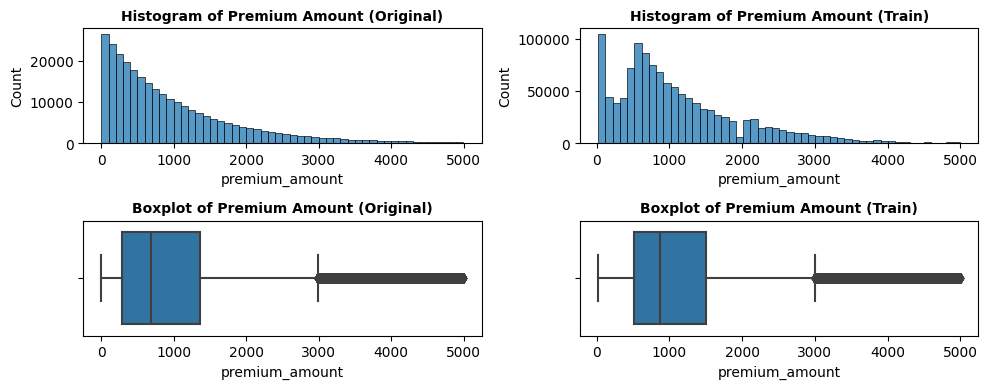

In [23]:
# Create a figure with subplots 
fig, axes = plt.subplots(2, 2, figsize=(10, 4)) 

# Histogram for the original dataset 
sns.histplot(original['premium_amount'], ax=axes[0, 0], kde=False, bins=50) 
axes[0, 0].set_title('Histogram of Premium Amount (Original)',fontsize=10, weight='bold') 

# Histogram for the train_df dataset 
sns.histplot(train_df['premium_amount'], ax=axes[0, 1], kde=False, bins=50) 
axes[0, 1].set_title('Histogram of Premium Amount (Train)', fontsize=10, weight='bold') 

# Boxplot for the original dataset 
sns.boxplot(x=original['premium_amount'], ax=axes[1, 0]) 
axes[1, 0].set_title('Boxplot of Premium Amount (Original)', fontsize=10, weight='bold') 

# Boxplot for the train_df dataset 
sns.boxplot(x=train_df['premium_amount'], ax=axes[1, 1]) 
axes[1, 1].set_title('Boxplot of Premium Amount (Train)', fontsize=10, weight='bold') 

# Adjust layout 
plt.tight_layout() 
plt.show()

In [24]:
print('Original Descriptive Stats:') 
print(original[['premium_amount']].describe())
print()
print('Train Descriptive Stats:')
print(train_df[['premium_amount']].describe())

Original Descriptive Stats:
       premium_amount
count       277019.00
mean           966.12
std            909.40
min              0.00
25%            286.00
50%            688.00
75%           1367.00
max           4999.00

Train Descriptive Stats:
       premium_amount
count      1200000.00
mean          1102.54
std            865.00
min             20.00
25%            514.00
50%            872.00
75%           1509.00
max           4999.00


The target variable **`premium_amount`** has a right-skewed distribution in both the original and train datasets. In the original dataset, the histogram shows a right-skewed distribution with each bin decreasing in size. In the train dataset, the distribution is also right-skewed, with a slight peak between 600 and 700. Outliers can be detected in the boxplots for both datasets.

# **Concatenate Original & Train Datasets**

After analyzing the data distribution of both categorical and numerical features, I decided to concatenate the original and train datasets. The shapes of the data distributions are consistent for each variable across all three datasets, as indicated by the histograms. However, the boxplotss for few variables (1 or 2) in the original dataset show wider values or outliers that are not present in the train and test datasets.

Given that both the train and test datasets were generated from a deep learning model trained on the original dataset, I wanted to verify whether there were any overlapping rows between the test and original datasets. Concatenating the original and train datasets is an optional step.

To confirm this, I ran a check using the following code:

In [25]:
from pandas.util import hash_pandas_object

# Drop the target variable (premium_amount) 
original_no_target = original.drop(columns=['premium_amount'])

# Hash rows for both datasets
original_hashes = hash_pandas_object(original_no_target, index=False)
test_hashes = hash_pandas_object(test_df, index=False)

# Convert hashes to set
original_hash_set = set(original_hashes)
test_hash_set = set(test_hashes)

# Check for duplicates
duplicates_hashes = original_hash_set.intersection(test_hash_set)

if duplicates_hashes:
    print(f'Duplicates found: {len(duplicates_hashes)} rows overlap between the original and test datasets')
else:
    print(f'No duplicates found. Proceeding to concatenate the original and train datasets.')

No duplicates found. Proceeding to concatenate the original and train datasets.


In [26]:
original['premium_amount'].isna().sum()

1841

In [27]:
# Drop rows with missing values in premium_amount 
original.dropna(subset=['premium_amount'], inplace=True)

# Concatenate original & train datasets
combined_df = pd.concat([original, train_df], ignore_index=True)
print('Shape of the combined_df dataset:\n', combined_df.shape)
print('Duplicates in combined_df:', combined_df.duplicated().sum())

Shape of the combined_df dataset:
 (1477019, 20)
Duplicates in combined_df: 0


In [28]:
combined_df['premium_amount'].isna().sum() 

0

# **Missing Values**

In [29]:
# Missing values in Original data  
original_count = original.isna().sum()
original_perct = round(original.isna().sum() / len(original) * 100, 2)

# Missing values in Train data
train_count = train_df.isna().sum()
train_perct = round(train_df.isna().sum() / len(train_df) * 100, 2)

# Missing values in Test data
test_count = test_df.isna().sum()
test_perct = round(test_df.isna().sum() / len(test_df) * 100, 2)

# Create a DataFrame for missing value summary for three datasets
missing_summary = pd.DataFrame({
    'original_count': original_count,
    'original_perct': original_perct,
    'train_count': train_count,
    'train_perct': train_perct,
    'test_count': test_count,
    'test_perct': test_perct
})

print('\n' + '='*85) 
print(f"{'SUMMARY OF MISSING VALUES ACROSS THREE DATASETS':^85}") 
print('='*85 + '\n')

missing_summary


                   SUMMARY OF MISSING VALUES ACROSS THREE DATASETS                   



,original_count,original_perct,train_count,train_perct,test_count,test_perct
age,4658.00,1.68,18705.00,1.56,12489.00,1.56
annual_income,13851.00,5.00,44949.00,3.75,29860.00,3.73
credit_score,27700.00,10.00,137882.00,11.49,91451.00,11.43
customer_feedback,18258.00,6.59,77824.00,6.49,52276.00,6.53
education_level,0.00,0.00,0.00,0.00,0.00,0.00
exercise_frequency,0.00,0.00,0.00,0.00,0.00,0.00
gender,0.00,0.00,0.00,0.00,0.00,0.00
health_score,10525.00,3.80,74076.00,6.17,49449.00,6.18
id,NaN,NaN,NaN,NaN,0.00,0.00
insurance_duration,0.00,0.00,1.00,0.00,2.00,0.00


The missing values across the three datasets reveals that the proportion of missing data ranges approximately from **2%** to **30%**. Importantly, the missing values percentages are consistent across all three datasets. While some features exhibit minimal or no missing values, others such as **`occupation`** and **`previous_claims`** have nearly **30%** missing data.

To effectively handle these missing values, it is essential to examine the missing value patterns. We need to determine whether these values are missing at random (MAR) or exibit correlation with other features. 

In [30]:
# Fillna with mean (as there are only few missing values in these columns)
combined_df['insurance_duration'].fillna(combined_df['insurance_duration'].mean(), inplace=True)
combined_df['vehicle_age'].fillna(combined_df['vehicle_age'].mean(), inplace=True) 

test_df['insurance_duration'].fillna(test_df['insurance_duration'].mean(), inplace=True)
test_df['vehicle_age'].fillna(test_df['vehicle_age'].mean(), inplace=True) 

In [31]:
# Check for missing values 
combined_df[['insurance_duration', 'vehicle_age']].isna().sum()

insurance_duration    0
vehicle_age           0
dtype: int64

In [32]:
combined_df.columns

Index(['age', 'gender', 'annual_income', 'marital_status',
       'number_of_dependents', 'education_level', 'occupation', 'health_score',
       'location', 'policy_type', 'previous_claims', 'vehicle_age',
       'credit_score', 'insurance_duration', 'policy_start_date',
       'customer_feedback', 'smoking_status', 'exercise_frequency',
       'property_type', 'premium_amount'],
      dtype='object')

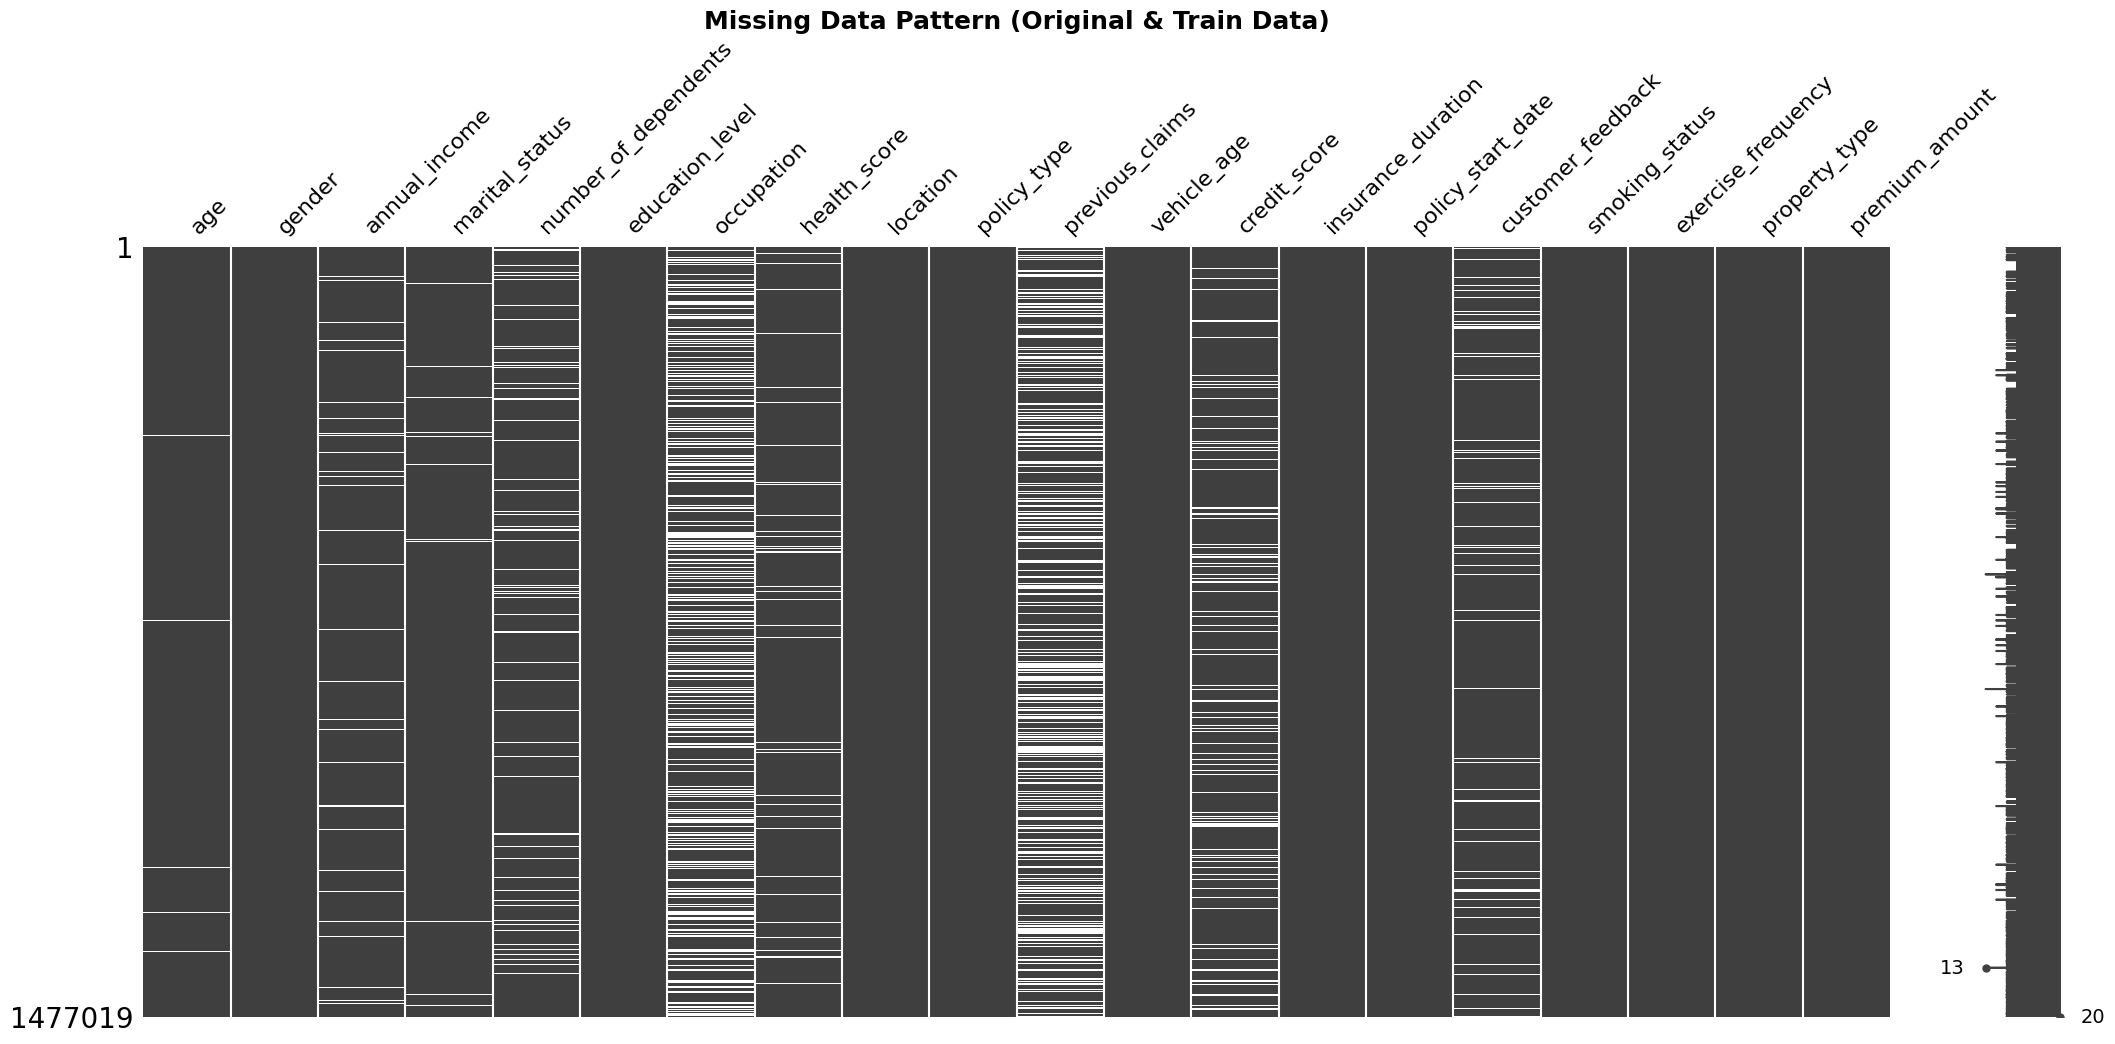

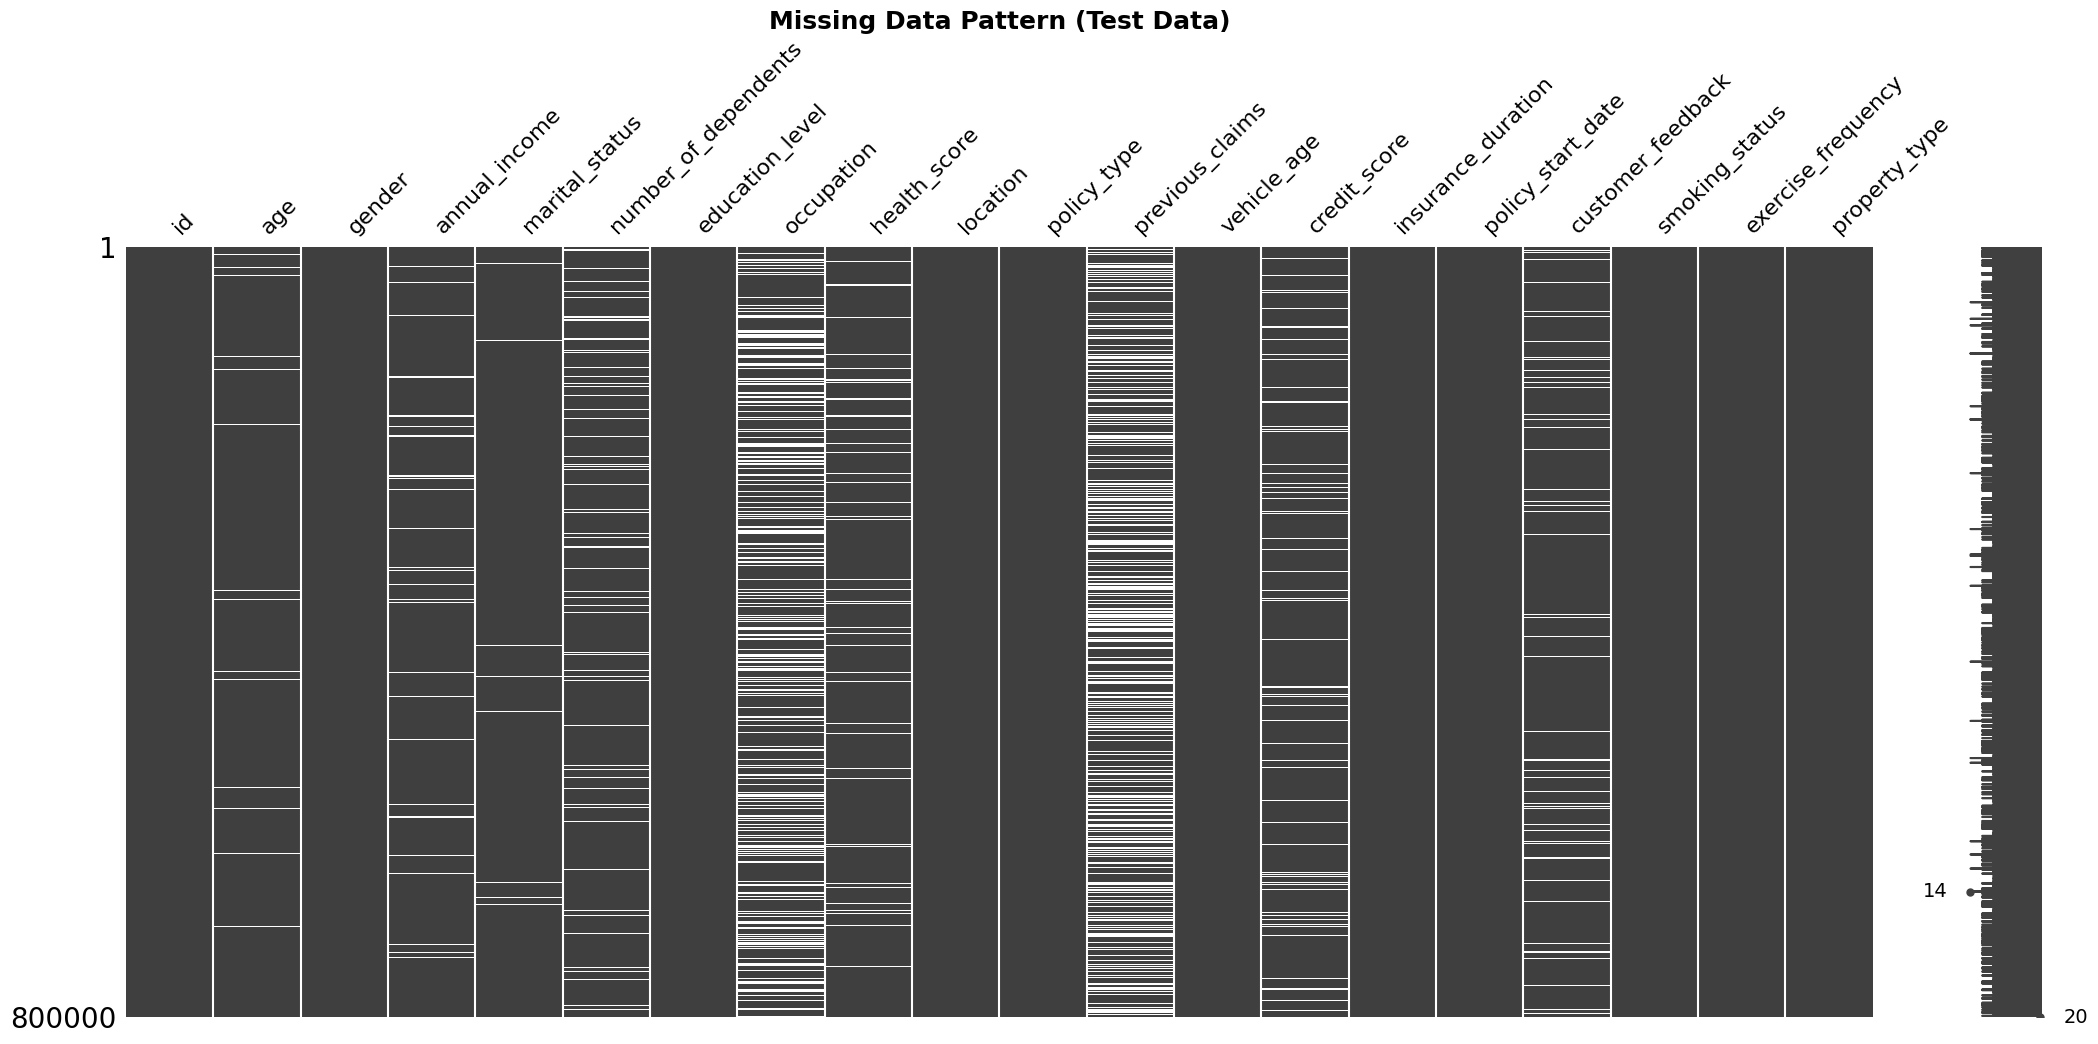

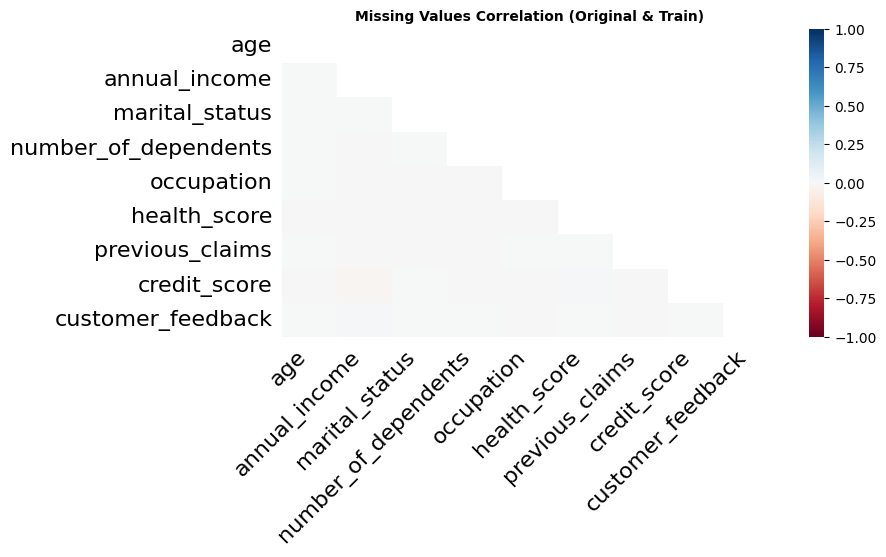

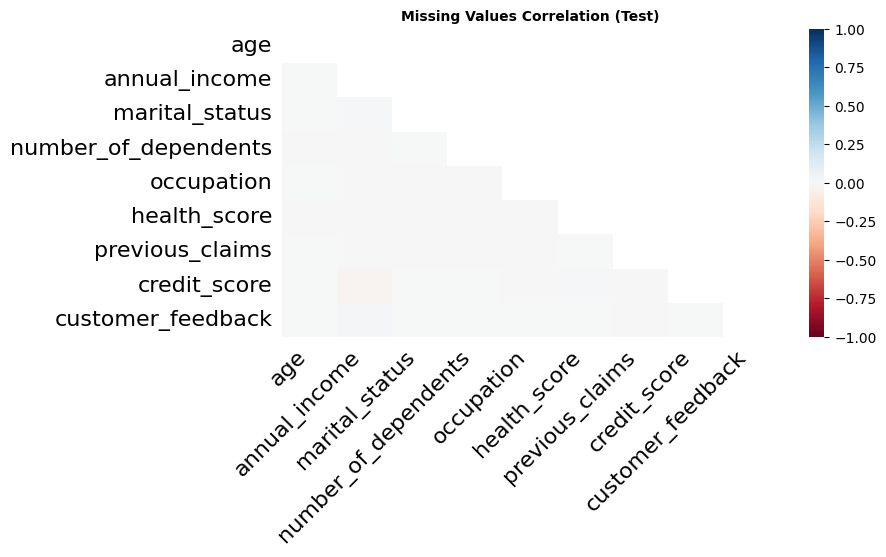

In [33]:
import missingno as msno

# Visualize missing data patterns
msno.matrix(combined_df)
plt.title('Missing Data Pattern (Original & Train Data)', size=18, weight='bold')
plt.show()

msno.matrix(test_df)
plt.title('Missing Data Pattern (Test Data)', size=18, weight='bold')
plt.show()

# Visualize missing data correlations
msno.heatmap(combined_df, figsize=(8, 4))
plt.title('Missing Values Correlation (Original & Train)', size=10, weight='bold')
plt.show()

msno.heatmap(test_df, figsize=(8, 4))
plt.title('Missing Values Correlation (Test)', size=10, weight='bold')
plt.show() 

The **`msno.matrix`** visualization indicates that the missing values across all features in both datasets appear more random with no clear pattern. Features such as **`previous_claims`** and **`occupation`** have significant missing values, but these values are scattered randomly rather than being clustered together. This suggests that the missingness is more likely to be **Missing at Random (MAR)**, as there doesn't seem to be a specific trend. 

The **`msno.heatmap`** visualization shows white cells for all features, indicating no significant correlation between the missing values of different features. This indicates that the missing values are not correlated with each other. The missingness in one feature does not predict or depend on the missingness in another feature, further supporting the observation that the data is **Missing  at Random (MAR)**.

## **Missing Value Imputation in Annual Income**

In [34]:
# Mean & Median for `annual_income`
combined_df['annual_income'].agg(['mean', 'median'])

mean     34480.19
median   24996.00
Name: annual_income, dtype: float64

In [35]:
# Mean & Median for `annual_income` by gender 
combined_df.groupby(['gender'])['annual_income'].agg(['mean', 'median'])

,mean,median
gender,,
Female,34488.40,24997.00
Male,34472.04,24986.00


In [36]:
# Mean & Median for `annual_income` by gender & `education_level`
combined_df.groupby(['gender', 'education_level'])['annual_income'].agg(['mean', 'median'])

mean   median
gender education_level                  
Female Bachelor's      34424.76 24983.00
       High School     34700.35 25136.00
       Master's        34425.91 24991.00
       PhD             34410.96 25011.00
Male   Bachelor's      34399.46 24982.50
       High School     34601.27 25006.00
       Master's        34493.13 24986.00
       PhD             34399.39 24984.00

The distribution of **`annual_income`** is right-skewed and contains outliers. To mitigate the influence of these outliers and the skewed distribution, we choose the median over the mean. The global median of **`annual_income`** is quite similar to the group-wise median by **`gender`** and by the **`gender`** and **`education_level`**. 

To respect the structure and distribution of income across different demographic groups in the dataset, we opt for group-wise imputation based on **`gender`** and **`education_level`**. Even though the differences are minor, the group-wise median offers a more nuanced imputation that accounts for small variations within these groups.

In [37]:
# Impute missing values in `annual_income` using median by `gender` and `education_level`
combined_df['annual_income'] = combined_df.groupby(
    ['gender', 'education_level'])['annual_income'].transform(
    lambda x: x.fillna(x.median())) 

# Impute missing values in `annual_income` in Test Data using median by `gender` and `education_level`
test_df['annual_income'] = test_df.groupby(
    ['gender', 'education_level'])['annual_income'].transform(
    lambda x: x.fillna(x.median())) 

# Check for missing values
print('Train:', combined_df['annual_income'].isna().sum())
print('Test:', combined_df['annual_income'].isna().sum())

Train: 0
Test: 0


## **Missing Value Imputation in Occupation**

In [38]:
# Create income bins & label 
income_bins = [0, 25000, 50000, 75000, 100000, float('inf')]
income_labels = ['Low', 'Low-Middle', 'Middle', 'Upper-Middle', 'High']

# Create`income_bin`
combined_df['income_bin'] = pd.cut(combined_df['annual_income'], bins=income_bins,
                                  labels=income_labels, include_lowest=True)

# Create`income_bin` in test data
test_df['income_bin'] = pd.cut(test_df['annual_income'], bins=income_bins,
                                  labels=income_labels, include_lowest=True)

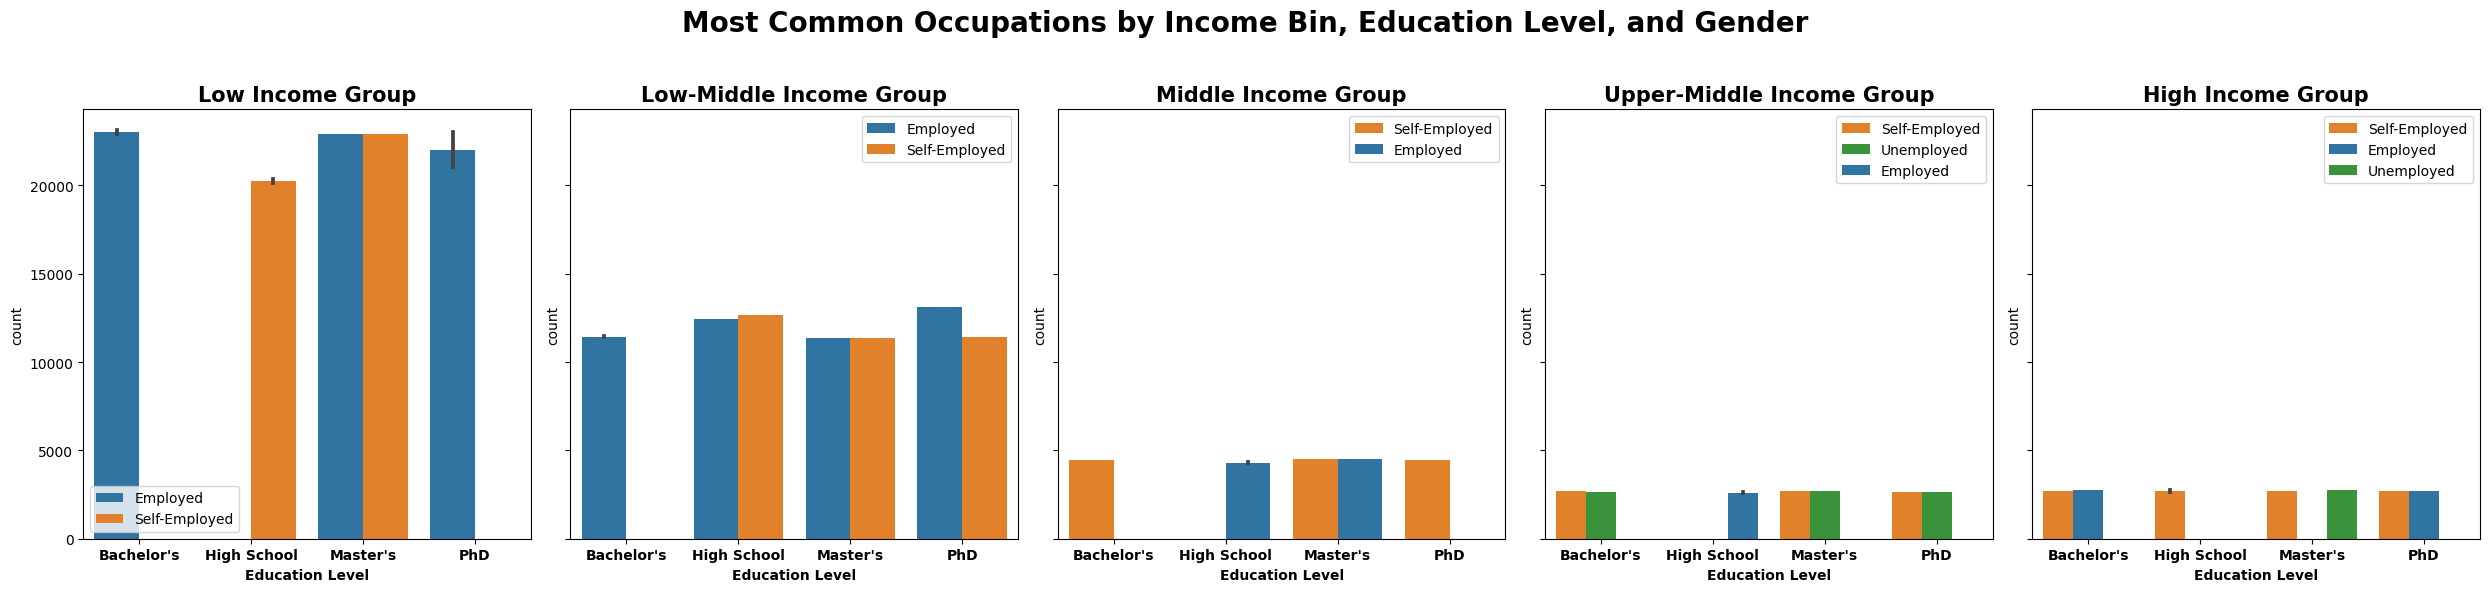

In [39]:
# Group by `income_bin`, `education_level`, and `occupation` & count occurrences
occupation_counts = combined_df.groupby(
    ['income_bin', 'education_level', 'gender'])['occupation'].value_counts().reset_index(name='count')

# Find the mode for each group 
mode_occupation = occupation_counts.loc[occupation_counts.groupby(
    ['income_bin', 'education_level', 'gender'])['count'].idxmax()]

# List of unique income_bin
income_bins = mode_occupation['income_bin'].unique() 

# Define a custom color palette for occupations 
occupation_palette = { 'Employed': '#1f77b4', 'Self-Employed': '#ff7f0e', 'Unemployed': '#2ca02c'}

# Set up the plot size & title
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True) 
fig.suptitle('Most Common Occupations by Income Bin, Education Level, and Gender', fontsize=20, weight='bold') 

# Plotting 
for i, income_bin in enumerate(income_bins):
    ax = axes[i] 
    subset = mode_occupation[mode_occupation['income_bin'] == income_bin] 
    sns.barplot(data=subset, x='education_level', y='count', palette=occupation_palette,
                hue='occupation', dodge=True, ax=ax) 
    ax.set_title(f'{income_bin} Income Group', size=15, weight='bold') 
    ax.set_xlabel('Education Level', fontdict=dict(weight='bold')) 
    ax.legend() 

    # Set the x-axis labels in bold
    for label in ax.get_xticklabels():
        label.set_weight('bold')
    
# Adjust layout 
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show() 

The above plots display bar plots for each **`income_bin`**, showing the most common occupation for each combination of **`education_level`** and **`gender`**. Each education level contains two bars, one for each gender, colored differently based on the **`occupation`**. If both genders have the same occupation within the same education level and income bin, the bars will appear together (single bar). Otherwise, there will be two distinct bars indicating the occupations. 

The above plots clearly show that our dataset has significant variability in occupation distributions across groups defined by **`income_bin`**, **`education_level`**, and **`gender`**. The plots indicate that the proportions of occupations differ not only by income level and education level but also by gender within those groups. While gender may not directly define occupation, it is relevant in the context of our dataset as it contributes to the observed variability in occupations within different income levels and education groups. 

Given that the **`occupation`** column has nearly **30%** of missing data, to ensure that the imputed values align with the patterns observed in the available data, we will perform group-wise imputation using the **`income_bin`**, **`education_level`**, and **`gender`** features. 

Although there are unemployed consumers across all income groups and education levels, it's interesting to note that the most common occupation (mode) among the upper-middle and high-income groups, as well as with different education level in these groups, is "unemployed." In contrast, for the lower, lower-middle, and middle-income groups, unemployment is not the most common occupation.

In [40]:
# Impute missing values in `occupation` using `income_bin`, `education_level`, and `gender`  
combined_df['occupation'] = combined_df.groupby(
    ['income_bin', 'education_level', 'gender'])['occupation'].transform(
    lambda x: x.fillna(x.mode()[0]))

# Impute missing values in `occupation` in Test data using `income_bin`, `education_level`, and `gender`
test_df['occupation'] = test_df.groupby(
    ['income_bin', 'education_level', 'gender'])['occupation'].transform(
    lambda x: x.fillna(x.mode()[0]))

# Check for missing values
print('Train:', combined_df['occupation'].isna().sum())
print('Test:', test_df['occupation'].isna().sum())

Train: 0
Test: 0


## **Missing Value Imputation in Credit Score**

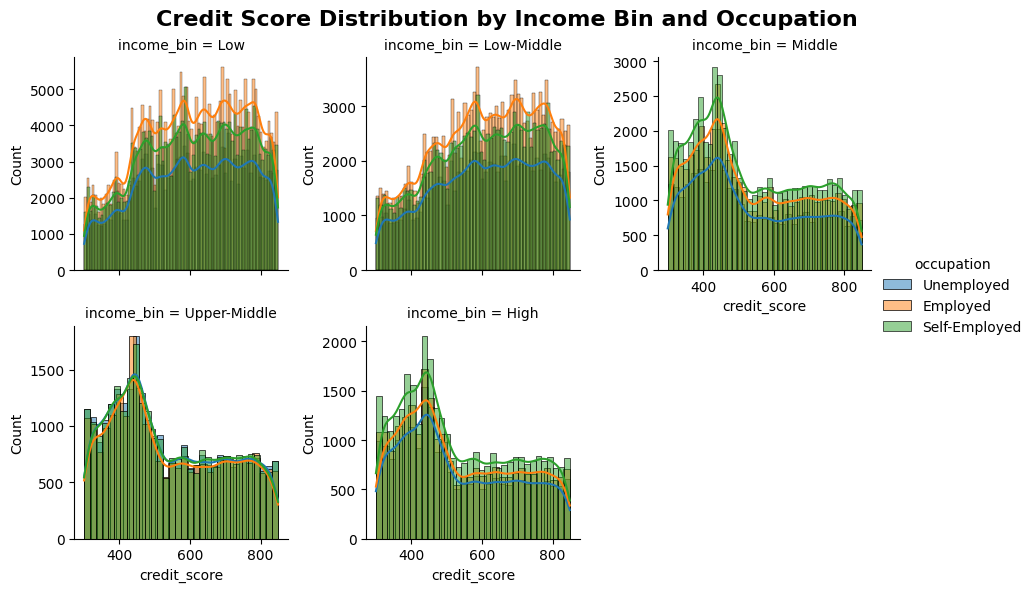

In [41]:
# Create a FacetGrid with overlaid histograms 
a = sns.FacetGrid(combined_df, col='income_bin', hue='occupation', 
                  col_wrap=3, height=3, sharey=False)
a.map(sns.histplot, 'credit_score', kde=True, alpha=0.5) 
a.add_legend() 
# Add a single title to the entire plot 
a.fig.suptitle('Credit Score Distribution by Income Bin and Occupation', fontsize=16, weight='bold') 
plt.subplots_adjust(top=0.9) 
plt.show()  

In the low and low-middle income groups, the data shows that more individuals are employed compared to those who are self-employed or unemployed. There are fewer people with credit scores below 400, and a higher concentration of people in the middle range of credit scores, between 450 and 700.

As income levels rise, the trend shifts. In the middle, upper-middle, and high income groups, self-employment becomes more prevalent compared to employed and unemployed. Notably, these higher income groups have more individuals with lower credit scores, while fewer have high credit scores. There is a noticeable peak in credit scores around 450 to 500 across all three occupational groups in these higher income bins.

This trend suggests that individuals with higher incomes are more likely to be self-employed. Conversely, the number of employed individuals is highest in the low and low-middle income bins and decreases as we move to higher income bins. Importantly, the data does not support the assumption that higher income groups have higher credit scores, nor that lower income groups have lower credit scores.

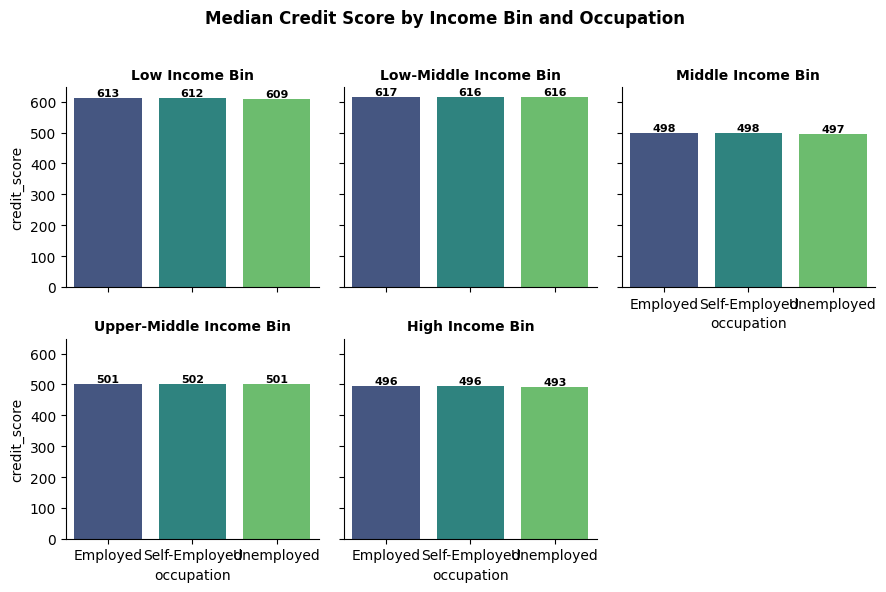

In [42]:
# Calculate median credit_score for each combination of income_bin and occupation
median_credit_score = combined_df.groupby(
    ['income_bin', 'occupation'])['credit_score'].median().reset_index()

# Set the order
order = median_credit_score['occupation'].unique()

# Plot
a = sns.FacetGrid(median_credit_score, col='income_bin', col_wrap=3, height=3)
a.map(sns.barplot, 'occupation', 'credit_score', order=order, palette='viridis')

# Add titles and adjust layout 
a.set_titles(col_template="{col_name} Income Bin", weight='bold') 
a.fig.suptitle('Median Credit Score by Income Bin and Occupation', fontsize=12, weight='bold') 
plt.subplots_adjust(top=0.85) 

# Add labels on top of the bars 
for ax in a.axes.flat:
  for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', fontsize=8, weight='bold') 

In [43]:
combined_df['credit_score'].describe()

count   1311437.00
mean        589.40
std         151.87
min         300.00
25%         463.00
50%         591.00
75%         719.00
max         849.00
Name: credit_score, dtype: float64

The credit scores in this dataset are generally on the lower side, with a mean of **589** and a median of **591**. Descriptive statistics reveal that **75%** of individuals in this dataset have a credit score below **719**, further highlighting the overall lower credit score distribution.

For imputing missing values in credit_score, we opted for group-wise imputation using **`occupation`** and **`income_bin`**. While the variation in credit scores across these groups is relatively minor, this method helps preserve the structure of the data and ensures the imputed values remain contextually relevant.

Given the absence of information such as repayment history, which could provide better insights for predicting credit scores, this approach offers a practical and efficient solution for handling missing data.

In [44]:
# Impute missing values in `credit_score` 
combined_df['credit_score'] = combined_df.groupby(
    ['occupation', 'income_bin'])['credit_score'].transform(
    lambda x: x.fillna(x.median()))

# Impute missing values in `credit_score` for Test data
test_df['credit_score'] = test_df.groupby(
    ['occupation', 'income_bin'])['credit_score'].transform(
    lambda x: x.fillna(x.median()))

print('Train:', combined_df['credit_score'].isna().sum())
print('Test:', test_df['credit_score'].isna().sum())

Train: 0
Test: 0


## **Missing Value Imputation in Health Score**

In [45]:
original[original['health_score'] >= 58.98].shape[0]

12172

In [46]:
# Get the maximum value from the train dataset
max_health_score = train_df['health_score'].max() 
# Cap all values above 58.98 to 58.98 
combined_df['health_score'] = combined_df['health_score'].clip(upper=max_health_score)

In [47]:
combined_df.groupby(['smoking_status', 'exercise_frequency'])['health_score'].median()

smoking_status  exercise_frequency
No              Daily                24.90
                Monthly              24.79
                Rarely               24.85
                Weekly               24.90
Yes             Daily                24.87
                Monthly              24.81
                Rarely               24.88
                Weekly               24.83
Name: health_score, dtype: float64

In [48]:
combined_df['health_score'].agg(['mean', 'median']) 

mean     26.12
median   24.85
Name: health_score, dtype: float64

In [49]:
# Impute missing values in `health_score` 
combined_df['health_score'] = combined_df.groupby(
    ['smoking_status', 'exercise_frequency'])['health_score'].transform(
    lambda x: x.fillna(x.median()))

# Impute missing values in `health_score` for Test data
test_df['health_score'] = test_df.groupby(
    ['smoking_status', 'exercise_frequency'])['health_score'].transform(
    lambda x: x.fillna(x.median()))

print('Train:', combined_df['health_score'].isna().sum())
print('Test:', test_df['health_score'].isna().sum())

Train: 0
Test: 0


The group-wise medians based on **`smoking_status`** and **`exercise_frequency`** are very close to the global median of **24.85**, which supports the idea that group-wise imputation is appropriate. This method captures slight variations in health scores across groups, ensuring that missing values are filled in a way that reflects meaningful patterns in the dataset. 

If gender is added to the grouping, it introduces only a minimal variation in the medians (differences of ~0.1–0.3). These differences are negligible and do not significantly deviate from the global median. 

## **Missing Value Imputation in Age & Number of Dependents**

In [50]:
combined_df.groupby(['gender'])['age'].median()

gender
Female   41.00
Male     41.00
Name: age, dtype: float64

In [51]:
combined_df.groupby(['gender', 'number_of_dependents'])['age'].median()

gender  number_of_dependents
Female  0.00                   41.00
        1.00                   41.00
        2.00                   41.00
        3.00                   41.00
        4.00                   41.00
Male    0.00                   41.00
        1.00                   41.00
        2.00                   41.00
        3.00                   41.00
        4.00                   41.00
Name: age, dtype: float64

The mean and median age is **41**. To ensure the robustness of our imputation strategy, we calculated group-wise medians for various combinations such as **`gender`** and **`age`**, **`gender`** and **`number_of_dependents`**, and other relevant categories. Remarkably, the median age consistently remained at 41 across all groups. Given this consistency, we will impute the missing data in the age column with the median age of 41.

In [52]:
combined_df['number_of_dependents'].describe()

count   1339658.00
mean          2.01
std           1.42
min           0.00
25%           1.00
50%           2.00
75%           3.00
max           4.00
Name: number_of_dependents, dtype: float64

In [53]:
combined_df.groupby(['gender'])['number_of_dependents'].median()

gender
Female   2.00
Male     2.00
Name: number_of_dependents, dtype: float64

In [54]:
combined_df.groupby(['gender', 'occupation'])['number_of_dependents'].median()

gender  occupation   
Female  Employed        2.00
        Self-Employed   2.00
        Unemployed      2.00
Male    Employed        2.00
        Self-Employed   2.00
        Unemployed      2.00
Name: number_of_dependents, dtype: float64

The mean and median **`number_of_dependents`** is **2**. We calculated group-wise medians for various combinations such as **`gender`** and **`number_of_dependents`**, as well as **`gender`**, **`occupation`**, and **`number_of_dependents`**. Despite these different groupings, the median number of dependents consistently remained at 2. Therefore, we will impute the missing data for the **`number_of_dependents`** using the median value of 2.

In [55]:
combined_df['age'].fillna(combined_df['age'].median(), inplace=True)
combined_df['number_of_dependents'].fillna(combined_df['number_of_dependents'].median(), inplace=True)

test_df['age'].fillna(test_df['age'].median(), inplace=True)
test_df['number_of_dependents'].fillna(test_df['number_of_dependents'].median(), inplace=True)

print('Missing values in age')
print('Train:', combined_df['age'].isna().sum())
print('Test:', test_df['age'].isna().sum())
print()
print('Missing values in number_of_dependents')
print('Train:', combined_df['number_of_dependents'].isna().sum())
print('Test:', test_df['number_of_dependents'].isna().sum())

Missing values in age
Train: 0
Test: 0

Missing values in number_of_dependents
Train: 0
Test: 0


## **Missing Value Imputation in Marital Status**

The mode, or most common **`marital_status`**, is **'single'**. Calculated the group-wise mode for marital status based on **`gender`** and **`number_of_dependents`**. Notably, there was variation among these groups, indicating that marital status differs significantly across different demographics. Therefore, instead of imputing the missing data with the overall mode, we will impute the missing data for marital status using the group-wise mode. This method ensures that the imputation is more representative and accurately reflects the diversity within the dataset.

In [56]:
combined_df['marital_status'].mode()

0    Single
Name: marital_status, dtype: object

In [57]:
# Impute missing values in `marital_status` using `gender` and `number_of_dependents`
combined_df['marital_status'] = combined_df.groupby(
    ['gender', 'number_of_dependents'])['marital_status'].transform(
    lambda x: x.fillna(x.mode()[0]))

# Impute missing values in `marital_status` in Test data using `gender` and `number_of_dependents`
test_df['marital_status'] = test_df.groupby(
    ['gender', 'number_of_dependents'])['marital_status'].transform(
    lambda x: x.fillna(x.mode()[0]))

# Check for missing values
print('Train:', combined_df['marital_status'].isna().sum())
print('Test:', test_df['marital_status'].isna().sum())

Train: 0
Test: 0


## **Missing Value Imputation in Customer Feedback**

The most common customer feedback is **'average'**. To handle the missing data in the customer feedback column, we will use group-wise imputation based on **`gender`**, **`occupation`**, and **`income_bin`**. This approach allows us to capture the nuances and differences in feedback patterns across various demographic segments. 

In [58]:
combined_df['customer_feedback'].mode() 

0    Average
Name: customer_feedback, dtype: object

In [59]:
# Impute missing values in `customer_feedback` using `gender`, `occupation` and `income_bin`
combined_df['customer_feedback'] = combined_df.groupby(
    ['gender', 'occupation', 'income_bin'])['customer_feedback'].transform(
    lambda x: x.fillna(x.mode()[0]))

# Impute missing values in `customer_feedback` in Test data using `gender` `occupation` and `income_bin`
test_df['customer_feedback'] = test_df.groupby(
    ['gender', 'occupation', 'income_bin'])['customer_feedback'].transform(
    lambda x: x.fillna(x.mode()[0]))

# Check for missing values
print('Train:', combined_df['customer_feedback'].isna().sum())
print('Test:', test_df['customer_feedback'].isna().sum())  

Train: 0
Test: 0


## **Missing Value Imputation in Previous Claims**

The median number of **`previous_claims`** is **1**. We calculated group-wise medians for various combinations, but the median remained consistent across all groups at **1**. Given this consistency, we will impute the missing data for previous claims using the median value. 

In [60]:
combined_df['previous_claims'].fillna(combined_df['previous_claims'].median(), inplace=True)
test_df['previous_claims'].fillna(test_df['previous_claims'].median(), inplace=True)

# Check for missing values
print('Train:', combined_df['previous_claims'].isna().sum())
print('Test:', test_df['previous_claims'].isna().sum())

Train: 0
Test: 0


In [61]:
print('Missing Values in Train:\n',combined_df.isna().sum().sum())
print()
print('Missing Values in Test:\n',test_df.isna().sum().sum())

Missing Values in Train:
 0

Missing Values in Test:
 0


In [62]:
combined_df['previous_claims'] = combined_df['previous_claims'].astype(int)
combined_df['number_of_dependents'] = combined_df['number_of_dependents'].astype(int)

test_df['previous_claims'] = test_df['previous_claims'].astype(int)
test_df['number_of_dependents'] = test_df['number_of_dependents'].astype(int)

# **Extract Temporal Features**

In [63]:
# Extract temporal features from `policy_start_date` for combined_df (original & train_df) 
combined_df['year'] = combined_df['policy_start_date'].dt.year
combined_df['month'] = combined_df['policy_start_date'].dt.month

# Extract temporal features from policy_start_date` for test_df
test_df['year'] = test_df['policy_start_date'].dt.year
test_df['month'] = test_df['policy_start_date'].dt.month  

# **Correlation**

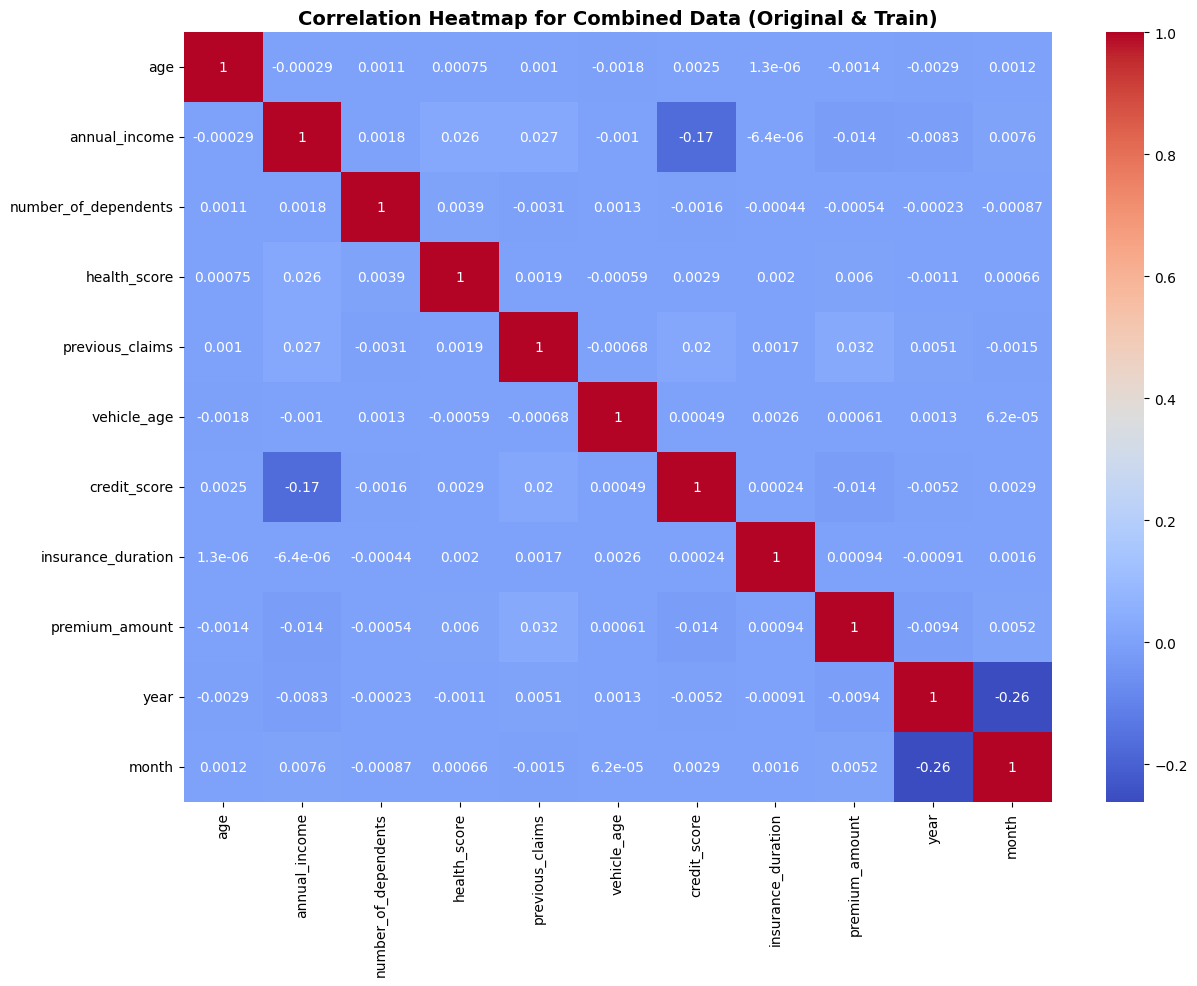

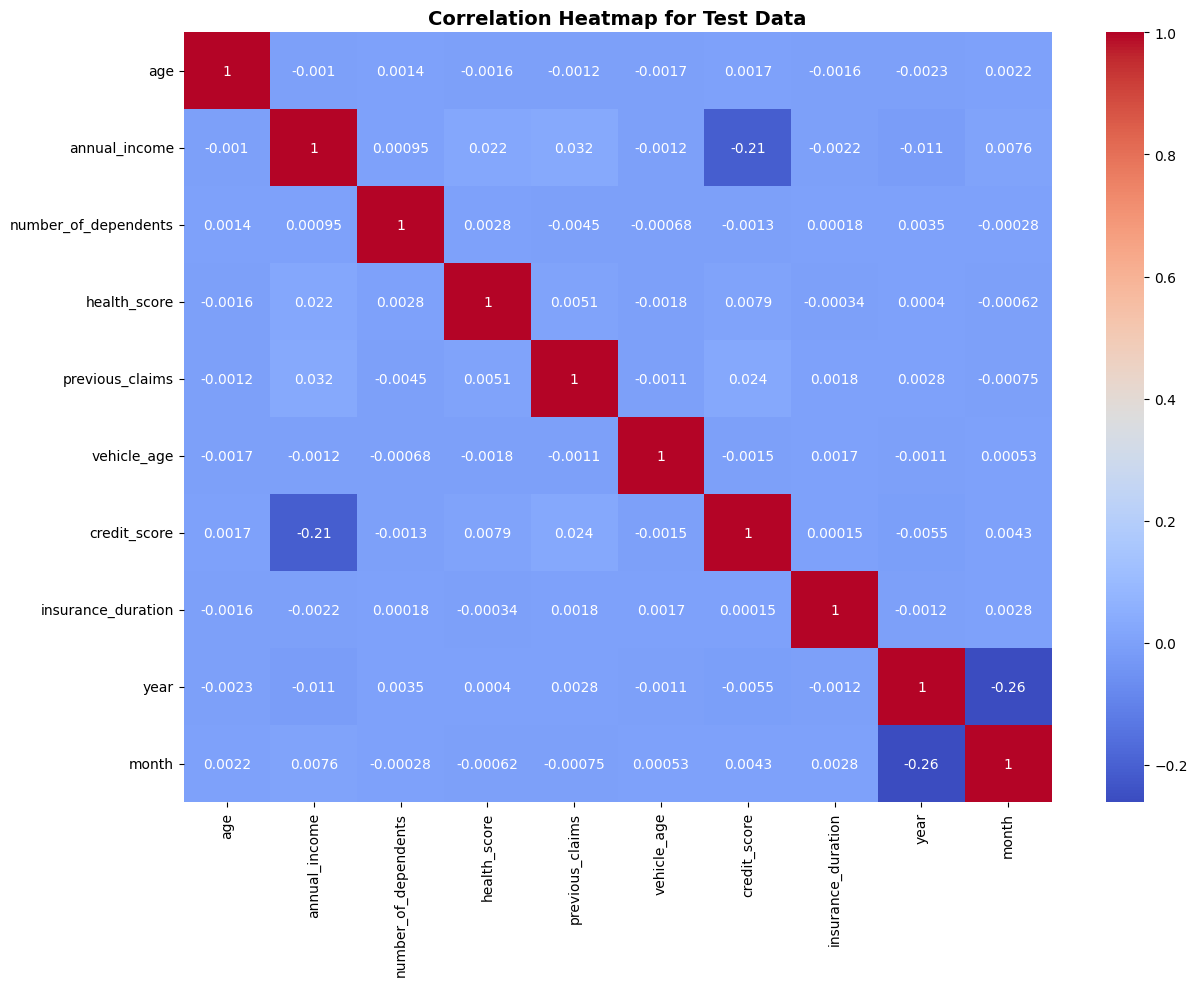

In [64]:
# Plot correlation heatmap for combined data (original & train_df)
plt.figure(figsize=(14, 10))
sns.heatmap(combined_df.corr(method='pearson', numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Combined Data (Original & Train)', fontsize=14, weight='bold');

# Plot correlation heatmap for test data 
plt.figure(figsize=(14, 10))
sns.heatmap(test_df.drop(columns=['id']).corr(method='pearson', numeric_only=True), 
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Test Data', fontsize=14, weight='bold');

The heatmap indicates that none of the features have a strong correlation with the target variable (**`premium_amount`**). **`previous_claims`** have a weak correlation of **0.032** with the **`premium_amount`** in the training dataset. **`credit_score`** and **`annual_income`** show negative correlation coefficients of **-0.21** in the test set and **-0.17** in the combined dataset, indicating very weak relationships. These weak correlations suggest that the features in the dataset do not have a significant linear relationship with the target variable.

# **Evaluating Premium Amount Trends by Various Factors**

By comparing premium amount trends across different factors such as property type, location, policy type, year, month, and previous claims, we can better understand their influence. This analysis can identify patterns and potential drivers of premium variations.

In [65]:
# Descriptive Statistics of `premium_amount` by `property_type`
combined_df.groupby('property_type')['premium_amount'].describe() 

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,492246.00,1078.57,876.92,0.00,469.00,836.00,1486.00,4999.00
Condo,491791.00,1076.09,875.89,0.00,467.00,835.00,1485.00,4999.00
House,492982.00,1076.21,872.55,0.00,469.00,840.00,1483.00,4999.00


In [66]:
# Descriptive Statistics of `premium_amount` by `policy_type`
combined_df.groupby('policy_type')['premium_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
policy_type,,,,,,,,
Basic,490993.00,1077.81,875.27,0.00,469.00,839.00,1486.00,4999.00
Comprehensive,491499.00,1077.36,875.20,0.00,468.00,838.00,1484.00,4997.00
Premium,494527.00,1075.71,874.89,0.00,468.00,835.00,1484.00,4999.00


In [67]:
# Descriptive Statistics of `premium_amount` by `location`
combined_df.groupby('location')['premium_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Rural,492983.00,1076.18,875.69,0.00,468.00,836.00,1485.00,4997.00
Suburban,494415.00,1076.72,874.62,0.00,467.00,837.00,1484.00,4999.00
Urban,489621.00,1077.98,875.05,0.00,470.00,839.00,1484.00,4999.00


The descriptive statistics indicate that the premium amounts for different **`property_types`** (Apartment, Condo, and House) are quite similar. The means and standard deviations are almost identical, and the minimum, 25%, 50% (median), 75%, and maximum values are also very close to each other. This indicates that there is no significant difference in the premium amount across different property types within this dataset. This pattern extends to **`location`** and **`policy_types`**, suggesting that premium amounts do not significantly vary based on these factors within this dataset. It implies that these factors may not be influential in determining the premium amount.

In [68]:
# Descriptive Statistics of `premium_amount` by `year`
combined_df.groupby('year')['premium_amount'].describe() 

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2019,104886.00,1145.72,919.29,0.00,483.00,902.00,1619.00,4993.00
2020,297384.00,1073.42,870.65,0.00,470.00,834.00,1477.00,4997.00
2021,300669.00,1068.98,869.04,0.00,468.00,832.00,1465.00,4997.00
2022,301248.00,1068.91,866.15,0.00,469.00,834.00,1466.00,4999.00
2023,294015.00,1070.60,873.01,0.00,464.00,832.00,1476.00,4999.00
2024,178817.00,1079.95,882.88,0.00,462.00,838.00,1492.00,4998.00


The analysis of **`premium_amount`** by **`year`** shows slight variations. While the means, medians, and standard deviations are fairly consistent, there are observable differences. In **2019**, the mean **(1145.72)**, median **(902)**, and standard deviation **(919.29)** are the highest. From **2020 to 2024**, the values are more consistent. Although the variations are not drastic, they suggest there might be some yearly influence on premium amounts.

In [69]:
# Descriptive Statistics of `premium_amount` by `month`
combined_df.groupby('month')['premium_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,121893.00,1071.25,872.33,0.00,466.00,833.00,1475.00,4996.00
2,117553.00,1076.40,877.67,0.00,467.00,832.00,1487.00,4999.00
3,126390.00,1076.85,872.18,0.00,471.00,842.00,1482.00,4988.00
4,123973.00,1069.94,867.88,0.00,468.00,834.00,1472.00,4994.00
5,129016.00,1068.50,867.83,0.00,467.00,831.00,1466.00,4997.00
6,121188.00,1073.48,871.19,0.00,466.00,834.00,1485.00,4997.00
7,124106.00,1069.94,869.37,0.00,468.00,832.00,1470.00,4997.00
8,124612.00,1076.10,876.84,0.00,467.00,837.00,1479.00,4996.00
9,122046.00,1086.66,883.98,0.00,467.00,849.00,1502.00,4993.00


The analysis of **`premium_amount`** by **`month`** shows slight variations. While the mean, median, and standard deviations are fairly consistent, there are some observable differences. Minor variations suggest that there might be some monthly influence on premium amounts, but the overall impact appears to be minimal.

In [70]:
# Descriptive Statistics of `premium_amount` by `previous_claims`
combined_df.groupby('previous_claims')['premium_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
previous_claims,,,,,,,,
0,377739.00,1060.25,868.38,0.00,457.00,827.00,1454.00,4999.00
1,818047.00,1062.18,867.62,0.00,461.00,828.00,1459.00,4999.00
2,203409.00,1134.79,897.18,0.00,511.00,893.00,1581.00,4993.00
3,60985.00,1155.45,910.72,0.00,513.00,921.00,1607.00,4988.00
4,13712.00,1185.99,931.03,0.00,513.00,940.00,1668.00,4982.00
5,2641.00,1173.92,933.35,3.00,513.00,919.00,1670.00,4988.00
6,395.00,1240.01,978.37,10.00,541.00,1012.00,1767.00,4955.00
7,79.00,1419.91,1028.10,15.00,608.00,1171.00,2133.00,4093.00
8,9.00,1182.22,932.56,63.00,481.00,1001.00,1691.00,3042.00


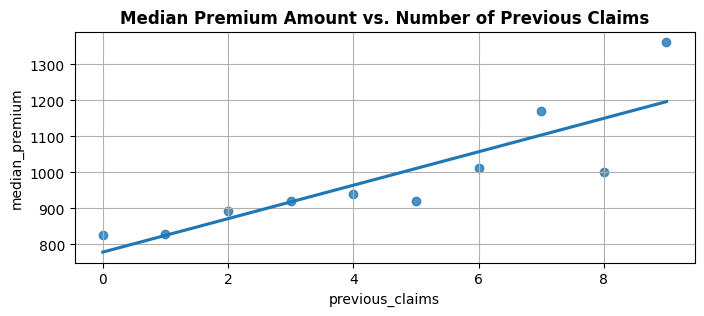

In [71]:
# Calculate medians for premium amounts grouped by previous_claims 
median_values = combined_df.groupby('previous_claims')['premium_amount'].median().reset_index()
# Update your data dictionary with these median values 
data = {'previous_claims': median_values['previous_claims'].tolist(), 'median_premium': median_values['premium_amount'].tolist()}

df = pd.DataFrame(data)

# Scatter plot with trend line 
plt.figure(figsize=(8, 3)) 
sns.regplot(data=df, x='previous_claims', y='median_premium', ci=None) 
plt.title('Median Premium Amount vs. Number of Previous Claims', fontsize=12, weight='bold') 
plt.grid(True) 
plt.show() 

The scatterplot with a regression line indicates a generally positive trend between the number of previous claims and the median premium amount. This aligns with the expectation that individuals with more previous claims tend to have higher premiums. This observation supports the idea that insurers may increase premiums as the number of claims rises, likely due to the perceived risk associated with repeat claims.

Additionally, the plot shows a clear upward trend in the median premium as the number of previous claims increases. However, this trend becomes less reliable for higher claim counts, particularly for previous_claims **> 5**. This inconsistency may be attributed to the presence of outliers or limited data for higher claim counts.

In [72]:
# Check number of rows with 0 premium_amount
print('Rows with zero premium amount:', combined_df[combined_df['premium_amount'] == 0].shape[0])

# Calculate median for `premium_amount`
premium_median = combined_df['premium_amount'].median()

# Replace 0 with median for the `premium_amount`
combined_df['premium_amount'] = combined_df['premium_amount'].replace(0, premium_median)

# Check number of rows with 0 premium_amount
print('Rows with zero premium amount after imputation:', combined_df[combined_df['premium_amount'] == 0].shape[0])

Rows with zero premium amount: 286
Rows with zero premium amount after imputation: 0


In [73]:
# Check number of rows with 0 annual_income
print('Rows with zero annual_income:', combined_df[combined_df['annual_income'] == 0].shape[0])

# Replace annual_income 0 with 1
combined_df['annual_income'] = combined_df['annual_income'].replace(0, 1)

# Check number of rows with 0 annual_income
print('Rows with zero annual income after imputation:',combined_df[combined_df['annual_income'] == 0].shape[0])

Rows with zero annual_income: 5
Rows with zero annual income after imputation: 0


# **Feature Engineering**

In [74]:
# Create Claim Frequency 
combined_df['claim_frequency'] = combined_df['previous_claims'] / combined_df['insurance_duration']
test_df['claim_frequency'] = test_df['previous_claims'] / test_df['insurance_duration']

# Create Policy Tenure Ratio
combined_df['policy_tenure_ratio'] = combined_df['insurance_duration'] / combined_df['age']
test_df['policy_tenure_ratio'] = test_df['insurance_duration'] / test_df['age']

# Create Claim Ratio per Year 
combined_df['claim_ratio_per_year'] = combined_df['previous_claims'] / (combined_df['insurance_duration'] / 12)
test_df['claim_ratio_per_year'] = test_df['previous_claims'] / (test_df['insurance_duration'] / 12)

# Create Credit Health Interaction
combined_df['credit_health_interaction'] = combined_df['credit_score'] * combined_df['health_score']
test_df['credit_health_interaction'] = test_df['credit_score'] * test_df['health_score']

# Create Claims to Income Ratio
combined_df['claims_to_income_ratio'] = (combined_df['previous_claims'] / combined_df['annual_income']) * 10000
test_df['claims_to_income_ratio'] = (test_df['previous_claims'] / test_df['annual_income']) * 10000

In [75]:
# Dependents to Income Ratio
combined_df['dependents_income_ratio'] = (combined_df['number_of_dependents'] / combined_df['annual_income']) * 10000
test_df['dependents_income_ratio'] = (test_df['number_of_dependents'] / test_df['annual_income']) * 10000

In [76]:
# Define a mapping dictionary
income_bin_mapping = {'Low': 1, 'Low-Middle': 2, 'Middle': 3, 'Upper-Middle': 4, 'High': 5}

# Map the income_bin labels to numeric values
combined_df['income_bracket'] = combined_df['income_bin'].map(income_bin_mapping)
test_df['income_bracket'] = test_df['income_bin'].map(income_bin_mapping)

print(combined_df[['income_bin', 'income_bracket']].head())

     income_bin income_bracket
0  Upper-Middle              4
1           Low              1
2    Low-Middle              2
3    Low-Middle              2
4        Middle              3


In [77]:
# Define age bins and corresponding labels as numbers
age_bins = [0, 25, 40, 60, float('inf')]
age_labels = [1, 2, 3, 4]  

# Apply binning to create the age_bracket feature
combined_df['age_bracket'] = pd.cut(combined_df['age'], bins=age_bins, labels=age_labels, include_lowest=True)
test_df['age_bracket'] = pd.cut(test_df['age'], bins=age_bins, labels=age_labels, include_lowest=True)

print(combined_df[['age', 'age_bracket']].head())

    age age_bracket
0 56.00           3
1 46.00           3
2 32.00           2
3 60.00           3
4 25.00           1


In [78]:
# Mapping for oridinal encoding
policy_type_mapping = {'Basic': 1, 'Premium': 2, 'Comprehensive': 3}
customer_feedback_mapping = {'Poor': 1, 'Average': 2, 'Good': 3}
education_level_mapping = {'High School': 1, "Bachelor's": 2, "Master's": 3, 'PhD': 4}
location_mapping = {'Rural': 1, 'Suburban': 2, 'Urban': 3}
exercise_mapping = {'Rarely': 1, 'Monthly': 2, 'Weekly': 3, 'Daily': 4}

# Create a Copy
encoded_df = combined_df.copy() 

encoded_df['policy_type_enco'] = encoded_df['policy_type'].map(policy_type_mapping)
encoded_df['customer_feedback_enco'] = encoded_df['customer_feedback'].map(customer_feedback_mapping)
encoded_df['education_level_enco'] = encoded_df['education_level'].map(education_level_mapping)
encoded_df['location_enco'] = encoded_df['location'].map(location_mapping)
encoded_df['exercise_enco'] = encoded_df['exercise_frequency'].map(exercise_mapping)


# Encode smoking status as binary
encoded_df['smoking_enco'] = np.where(encoded_df['smoking_status'] == 'Yes', 1, 0) 

## **Dummy Encoding** 

In [79]:
# Nominal features
nominal_col = ['gender', 'marital_status', 'occupation', 'property_type']

# Ordinal & Nominal features
cat_col = nominal_col + ['policy_type', 'customer_feedback', 
                         'education_level', 'location', 'smoking_status',
                         'exercise_frequency']

# Create dummy variables for nominal features
dummy_df = pd.get_dummies(encoded_df[nominal_col], drop_first=False)

# Concatenate dummy_df & combined_df
encoded_df = pd.concat([encoded_df, dummy_df], axis=1)
# Drop original categorical columns
encoded_df = encoded_df.drop(columns=cat_col)
# Drop other columns
encoded_df = encoded_df.drop(columns=['policy_start_date', 'income_bin'])

encoded_df.head() 

,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,premium_amount,year,month,claim_frequency,policy_tenure_ratio,claim_ratio_per_year,credit_health_interaction,claims_to_income_ratio,dependents_income_ratio,income_bracket,age_bracket,policy_type_enco,customer_feedback_enco,education_level_enco,location_enco,exercise_enco,smoking_enco,gender_Female,gender_Male,marital_status_Divorced,marital_status_Married,marital_status_Single,occupation_Employed,occupation_Self-Employed,occupation_Unemployed,property_type_Apartment,property_type_Condo,property_type_House
0,56.00,99990.00,1,31.07,1,13.00,320.00,5.00,308.00,2022,12,0.20,0.09,2.40,9943.88,0.10,0.10,4,3,3,1,3,3,4,1,False,True,False,True,False,False,False,True,False,True,False
1,46.00,2867.00,1,50.27,1,3.00,694.00,4.00,517.00,2023,1,0.25,0.09,3.00,34888.31,3.49,3.49,1,3,3,3,2,3,2,1,False,True,False,False,True,True,False,False,False,False,True
2,32.00,30154.00,3,14.71,2,16.00,652.00,8.00,849.00,2023,11,0.25,0.25,3.00,9594.12,0.66,0.99,2,2,3,1,2,2,2,0,True,False,True,False,False,True,False,False,False,False,True
3,60.00,48371.00,0,25.35,1,11.00,330.00,7.00,927.00,2023,2,0.14,0.12,1.71,8364.49,0.21,0.00,2,3,3,1,4,1,1,0,True,False,True,False,False,False,True,False,False,True,False
4,25.00,54174.00,0,6.66,1,9.00,498.00,8.00,303.00,2020,11,0.12,0.32,1.50,3316.43,0.18,0.00,3,1,3,1,1,3,1,0,True,False,True,False,False,False,True,False,False,True,False


In [80]:
# Create a Copy
encoded_test_df = test_df.copy()

# Mapping for oridinal encoding in test data
encoded_test_df['policy_type_enco'] = encoded_test_df['policy_type'].map(policy_type_mapping)
encoded_test_df['customer_feedback_enco'] = encoded_test_df['customer_feedback'].map(customer_feedback_mapping)
encoded_test_df['education_level_enco'] = encoded_test_df['education_level'].map(education_level_mapping)
encoded_test_df['location_enco'] = encoded_test_df['location'].map(location_mapping)
encoded_test_df['exercise_enco'] = encoded_test_df['exercise_frequency'].map(exercise_mapping)

# Encode smoking status as binary
encoded_test_df['smoking_enco'] = np.where(encoded_test_df['smoking_status'] == 'Yes', 1, 0)

In [81]:
# Create dummy variables for nominal features
test_dummy_df = pd.get_dummies(test_df[nominal_col], drop_first=False)

# Concatenate dummy_df & test_dummy_df
encoded_test_df = pd.concat([encoded_test_df, test_dummy_df], axis=1)
# Drop categorical columns
encoded_test_df = encoded_test_df.drop(columns=cat_col)
# Drop other columns
encoded_test_df = encoded_test_df.drop(columns=['policy_start_date', 'income_bin'])

encoded_test_df.head()

,id,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,year,month,claim_frequency,policy_tenure_ratio,claim_ratio_per_year,credit_health_interaction,claims_to_income_ratio,dependents_income_ratio,income_bracket,age_bracket,policy_type_enco,customer_feedback_enco,education_level_enco,location_enco,exercise_enco,smoking_enco,gender_Female,gender_Male,marital_status_Divorced,marital_status_Married,marital_status_Single,occupation_Employed,occupation_Self-Employed,occupation_Unemployed,property_type_Apartment,property_type_Condo,property_type_House
0,1200000,28.00,2310.00,4,7.66,1,19.00,615.00,1.00,2023,6,1.00,0.04,12.00,4709.66,4.33,17.32,1,2,1,1,2,1,3,1,True,False,True,False,False,False,True,False,False,False,True
1,1200001,31.00,126031.00,2,13.38,1,14.00,372.00,8.00,2024,4,0.12,0.26,1.50,4977.87,0.08,0.16,5,2,2,3,3,2,1,1,True,False,False,True,False,False,True,False,True,False,False
2,1200002,47.00,17092.00,0,24.35,1,16.00,819.00,9.00,2023,4,0.11,0.19,1.33,19946.36,0.59,0.00,1,3,3,2,4,3,2,1,True,False,True,False,False,False,False,True,False,True,False
3,1200003,28.00,30424.00,3,5.14,1,3.00,770.00,5.00,2023,10,0.20,0.18,2.40,3954.89,0.33,0.99,2,2,3,1,4,2,4,1,True,False,True,False,False,False,True,False,False,False,True
4,1200004,24.00,10863.00,2,11.84,1,14.00,755.00,7.00,2021,11,0.14,0.29,1.71,8942.34,0.92,1.84,1,1,2,2,1,2,3,0,False,True,True,False,False,False,False,True,False,False,True


In [82]:
encoded_df['age_bracket'] = encoded_df['age_bracket'].astype(int)
encoded_test_df['age_bracket'] = encoded_test_df['age_bracket'].astype(int)

encoded_df['income_bracket'] = encoded_df['income_bracket'].astype(int)
encoded_test_df['income_bracket'] = encoded_test_df['income_bracket'].astype(int)

In [83]:
check_missing_columns(encoded_df, encoded_test_df, name_1 = 'encoded_df', name_2 = 'encoded_test_df')

Comparing encoded_df & encoded_test_df: 
The following columns are missing in encoded_df dataset 
 {'id'}
Comparing encoded_df & encoded_test_df: 
The following columns are missing in encoded_test_df dataset 
 {'premium_amount'}


In [84]:
compare_data_types(encoded_df, encoded_test_df, name_1 = 'encoded_df', name_2 = 'encoded_test_df') 

Comparing between encoded_df & encoded_test_df: 
All common columns have matching data types between encoded_df and encoded_test_df


In [85]:
encoded_df.shape

(1477019, 36)

In [86]:
encoded_df[encoded_df['premium_amount'] < 0].shape[0]  

0

# **Model Construction**

In [87]:
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error

## **Traning & Evaluating on the Validation Set**

In [88]:
# Features and target variable
X = encoded_df.drop(columns=['premium_amount'])  
y = encoded_df['premium_amount']

# Split the training data into train and validation sets (80%-20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define custom RMSLE evaluation function
def rmsle_eval(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)  # This will ensure there is no negative prediction
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return rmsle

model = LGBMRegressor(
    boosting_type='gbdt',  
    objective='regression',  
    metric='None',  
    device='gpu',  
    gpu_platform_id=0,  
    gpu_device_id=0,  
    n_estimators=1000,  
    )

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  
    eval_metric=lambda y_true, y_pred: ('rmsle', rmsle_eval(y_true, y_pred), False), 
    callbacks=[early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 1181615, number of used features: 35
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 28 dense feature groups (31.55 MB) transferred to GPU in 0.036568 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1077.631371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[292]	valid_0's rmsle: 1.19926


LGBMRegressor(device='gpu', gpu_device_id=0, gpu_platform_id=0, metric='None',
              n_estimators=1000, objective='regression')

## **Training & Predicting on Full Dataset**

In [89]:
# Combine to form the full dataset
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

# Train the model on the full dataset
model_full = LGBMRegressor(
    boosting_type='gbdt',  
    objective='regression',  
    metric='None',  
    device='gpu',  
    gpu_platform_id=0,  
    gpu_device_id=0,  
    n_estimators=1000
)

model_full.fit(
    X_full, y_full,
    eval_metric=lambda y_true, y_pred: ('rmsle', rmsle_eval(y_true, y_pred), False)
)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2022
[LightGBM] [Info] Number of data points in the train set: 1477019, number of used features: 35
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 28 dense feature groups (39.44 MB) transferred to GPU in 0.048995 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1077.119790


LGBMRegressor(device='gpu', gpu_device_id=0, gpu_platform_id=0, metric='None',
              n_estimators=1000, objective='regression')

In [90]:
# Make predictions on the full training set
y_full_pred = model_full.predict(X_full)

# Calculate RMSLE
rmsle_full_train = rmsle_eval(y_full, y_full_pred)
print(f"RMSLE on the full training set: {rmsle_full_train:.6f}")   

RMSLE on the full training set: 1.188084


## **Feature Importance**

In [91]:
# Feature Importance (gain)
importance_gain = model_full.booster_.feature_importance(importance_type='gain') 
# Create DataFrame
feature_importance_gain = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance (Gain)': importance_gain
})
feature_importance_gain = feature_importance_gain.sort_values(by='Importance (Gain)', ascending=False)
feature_importance_gain = feature_importance_gain.reset_index(drop=True)
feature_importance_gain 

,Feature,Importance (Gain)
0,annual_income,73853851071.00
1,health_score,62283499835.00
2,credit_score,46249154494.00
3,year,20510858593.00
4,previous_claims,17229302685.00
5,credit_health_interaction,16409124595.00
6,claims_to_income_ratio,15648796019.00
7,policy_tenure_ratio,14640369243.00
8,dependents_income_ratio,11712483347.00
9,age,10589329010.00


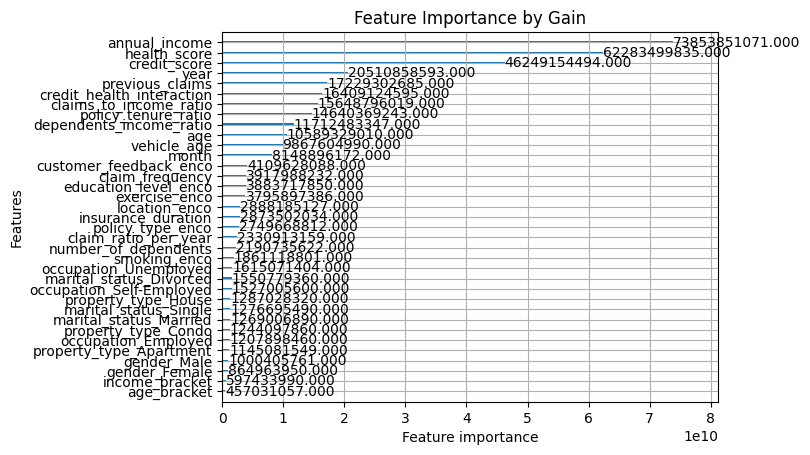

In [92]:
# Plot Feature Importance (gain)
lgb.plot_importance(model_full.booster_, importance_type = 'gain')
plt.title('Feature Importance by Gain');

In [93]:
# Feature Importance (split)
importance_split = model_full.booster_.feature_importance(importance_type='split')
# Create DataFrame
feature_importance_split = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance (Split)': importance_split
})
feature_importance_split = feature_importance_split.sort_values(by='Importance (Split)', ascending=False)
feature_importance_split = feature_importance_split.reset_index(drop=True)
feature_importance_split

,Feature,Importance (Split)
0,credit_score,3345
1,annual_income,3024
2,health_score,2896
3,credit_health_interaction,2344
4,policy_tenure_ratio,2259
5,claims_to_income_ratio,1872
6,dependents_income_ratio,1777
7,age,1675
8,vehicle_age,1556
9,month,1257


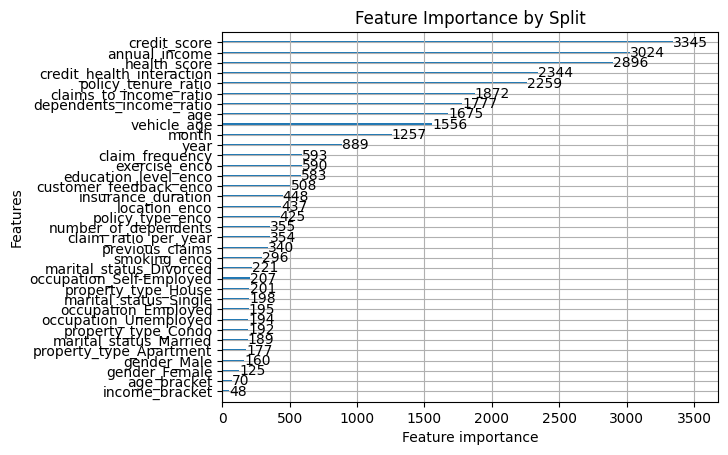

In [94]:
# Plot Feature Importance (split)
lgb.plot_importance(model_full.booster_, importance_type = 'split')
plt.title('Feature Importance by Split');

### **Top Features:**
* **`annual_income`**, **`health_score`**, and **`credit_score`** are consistently at the top in both importance metrics (gain and split).
* Four newly created features - **`credit_health_interaction`**, **`claims_to_income_ratio`**, **`policy_tenure_ratio`**, and **`dependents_income_ratio`** — are among the top **10** in both gain and split importance.

### **Temporal Features:**
* **`year`** ranked **4th** in gain and **11th** in split, which indicate moderate importance.
* **`month`** ranked **10th** in split and **12th** in gain, which indicate some relevance.

### **Least Important Features:** 
* **`income_bracket`**, **`age_bracket`**, **`gender`**, **`marital_status`**, **`occupation`**, **`property_type`**, **`location`** have lowest importance scores, suggesting they do not significantly impact the target variable. 


# **Improving the Model**
**Feature Selection:** To enhance our model, the first step is to remove features with low importance scores. This step will streamline the model and focus on the most impactful variables.

**Target Variable Transformation:** The target variable, **`premium_amount`**, has a right-skewed distribution with outliers and extreme values. To address this, we will log-transform the target variable. This transformation will make it more suitable for the **Root Mean Squared Logarithmic Error (RMSLE)**.

By removing low-importance features and log-transforming the target variable, we can improve the model's performance and ensure that it handles the data's characteristics more effectively.

In [95]:
# Remove features with low importance 
encoded_df = encoded_df.drop(columns=['gender_Male', 'gender_Female', 'age_bracket', 
                                      'income_bracket', 'occupation_Employed', 'occupation_Self-Employed', 
                                      'occupation_Unemployed', 'marital_status_Divorced','marital_status_Married',
                                      'marital_status_Single', 'property_type_Apartment', 'property_type_Condo',
                                      'property_type_House']) 

In [96]:
encoded_df.shape

(1477019, 23)

In [97]:
# Log transform target variable `premium_amount`
encoded_df['premium_amount'] = np.log1p(encoded_df['premium_amount'])

In [98]:
# Custom RMSLE 
def rmsle(y_true, y_pred):
    y_true_original = np.expm1(y_true)
    y_pred_original = np.expm1(y_pred)
    y_pred_original = np.maximum(y_pred_original, 0)
    return np.sqrt(mean_squared_log_error(y_true_original, y_pred_original))

# Wrapper to handle the estimator
from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## **Create Stratified Sample Data**
To optimize hyper-parameter tuning using RandomSearchCV, we will take a stratified sample from our **1.4M** observation dataset. We will sample **40%** of the data, creating quantile bins to divide the premium amount into **10 quantiles**. This step will ensure that the entire range of premium amounts is represented proportionally in the sample.

This approach will further help us manage the right-skewed distribution by ensuring that samples from different parts of the distribution (low to high premium amounts) are included. By following this method, we achieve a balanced sample that is representative of the whole population.

In [99]:
'''
# Quantile bins for stratified sampling
bins = pd.qcut(encoded_df['premium_amount'], q=10, labels=False)

# Add bins
encoded_df['premium_bins'] = bins

# Stratified sampling based on bins
sampled_data = encoded_df.groupby('premium_bins', group_keys=False).apply(
    lambda x: x.sample(frac=0.40, random_state=42)
)

# Drop the premium_bins column
sampled_data = sampled_data.drop(columns=['premium_bins'])
encoded_df = encoded_df.drop(columns=['premium_bins'])

sampled_data.shape
'''  

"\n# Quantile bins for stratified sampling\nbins = pd.qcut(encoded_df['premium_amount'], q=10, labels=False)\n\n# Add bins\nencoded_df['premium_bins'] = bins\n\n# Stratified sampling based on bins\nsampled_data = encoded_df.groupby('premium_bins', group_keys=False).apply(\n    lambda x: x.sample(frac=0.40, random_state=42)\n)\n\n# Drop the premium_bins column\nsampled_data = sampled_data.drop(columns=['premium_bins'])\nencoded_df = encoded_df.drop(columns=['premium_bins'])\n\nsampled_data.shape\n"

In [100]:
'''
# Separate features & target 
X_sample = sampled_data.drop(columns=['premium_amount'])
y_sample = sampled_data['premium_amount']

# Define a parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127, 255],
    'max_depth': [5, 6, 7, 8],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1]
}
# LightGBM Model for RandomizedSearchCV
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', device='gpu', random_state=42, verbose=-1)
'''

"\n# Separate features & target \nX_sample = sampled_data.drop(columns=['premium_amount'])\ny_sample = sampled_data['premium_amount']\n\n# Define a parameter grid\nparam_grid = {\n    'n_estimators': [100, 200, 300, 500],\n    'learning_rate': [0.01, 0.05, 0.1],\n    'num_leaves': [31, 63, 127, 255],\n    'max_depth': [5, 6, 7, 8],\n    'min_child_samples': [20, 30, 50],\n    'subsample': [0.6, 0.7, 0.8],\n    'colsample_bytree': [0.6, 0.7, 0.8],\n    'reg_alpha': [0.1],\n    'reg_lambda': [0.1]\n}\n# LightGBM Model for RandomizedSearchCV\nlgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', device='gpu', random_state=42, verbose=-1)\n"

In [101]:
'''
from sklearn.model_selection import RandomizedSearchCV

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, cv=5, n_iter=30,
                                   scoring=rmsle_scorer, verbose=2, n_jobs=-1, random_state=42)
# Perform Grid Search
random_search.fit(X_sample, y_sample)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params) 
print()

print('best_score:', random_search.best_score_)   
'''

'\nfrom sklearn.model_selection import RandomizedSearchCV\n\n# Set up RandomizedSearchCV\nrandom_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, cv=5, n_iter=30,\n                                   scoring=rmsle_scorer, verbose=2, n_jobs=-1, random_state=42)\n# Perform Grid Search\nrandom_search.fit(X_sample, y_sample)\n\n# Best parameters\nbest_params = random_search.best_params_\nprint("Best Parameters:", best_params) \nprint()\n\nprint(\'best_score:\', random_search.best_score_)   \n'

## **Model Training and Cross-Validation Using Optimized Hyper-Parameters**
The next step is to train our model using the best hyper-parameters found. It performs **10-fold** cross-validation to evaluate the model’s performance. The **`cross_val_score`** function is used to compute **RMSLE** scores for each fold, and the results are printed, showing the individual fold scores, the **mean RMSLE**, and the **standard deviation.** This process helps in assessing the model’s robustness and consistency across different subsets of the data.

In [102]:
from sklearn.model_selection import cross_val_score

# Features and target variable
X = encoded_df.drop(columns=['premium_amount'])  
y = encoded_df['premium_amount']

best_params = {'subsample': 0.7, 
               'reg_lambda': 0.1, 
               'reg_alpha': 0.1, 
               'num_leaves': 255, 
               'n_estimators': 300, 
               'min_child_samples': 50, 
               'max_depth': 5, 
               'learning_rate': 0.01, 
               'colsample_bytree': 0.6}

# Train final model with the best parameters
final_model_lgbm = lgb.LGBMRegressor(**best_params, boosting_type='gbdt', objective='regression', device='gpu', 
                                     random_state=11, verbose=-1)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(final_model_lgbm, X, y, cv=10, scoring=rmsle_scorer, n_jobs=-1)  

# Print Cross-Validation Results
print("Cross-Validation RMSLE Scores: ", -cv_scores)  # Convert negative scores to positive for RMSLE
print("Mean RMSLE: ", -cv_scores.mean())
print("Standard Deviation: ", cv_scores.std())   

Cross-Validation RMSLE Scores:  [1.28001917 1.24982502 1.07001922 1.07029206 1.07437491 1.06525416
 1.0731245  1.07009461 1.06787036 1.06471554]
Mean RMSLE:  1.1085589542241077
Standard Deviation:  0.07852460755025471


In [103]:
# Train the model on the full training dataset
final_model_lgbm.fit(X, y)  

LGBMRegressor(colsample_bytree=0.6, device='gpu', learning_rate=0.01,
              max_depth=5, min_child_samples=50, n_estimators=300,
              num_leaves=255, objective='regression', random_state=11,
              reg_alpha=0.1, reg_lambda=0.1, subsample=0.7, verbose=-1)

In [104]:
# Make predictions on the full training dataset  
y_final_pred = final_model_lgbm.predict(X) 

In [105]:
# Calculate RMSLE  
rmsle_final = rmsle(y, y_final_pred)
print(f"RMSLE on the full training set: {rmsle_final:.6f}")  

RMSLE on the full training set: 1.108502


## **Predicting on the Test Dataset**

In [106]:
# Extract 'id' column from the test data 
test_ids = encoded_test_df['id']

# Remove 'id' column from the test data
X_test = encoded_test_df.drop(columns=['id'])

In [107]:
# Drop columns with low feature importance
X_test = X_test.drop(columns=['gender_Male', 'gender_Female', 'age_bracket', 
                              'income_bracket', 'occupation_Employed', 'occupation_Self-Employed', 
                              'occupation_Unemployed', 'marital_status_Divorced','marital_status_Married',
                              'marital_status_Single', 'property_type_Apartment', 'property_type_Condo',
                              'property_type_House'])

# Check train & test set has same columns
check_missing_columns(X, X_test, name_1 = 'X', name_2 = 'X_test')

Both X and X_test datasets contains the same columns.


In [108]:
# Predict on the test data
y_test_final_pred = final_model_lgbm.predict(X_test)

# Converting log predictions back to original values
y_test_final_pred = np.expm1(y_test_final_pred)

In [109]:
# Ensure no negative predictions
y_test_final_pred = np.maximum(y_test_final_pred, 0)

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'Premium Amount': y_test_final_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Final submission file created")

Final submission file created


In [110]:
submission.head()   

,id,Premium Amount
0,1200000,692.00
1,1200001,710.01
2,1200002,747.52
3,1200003,753.66
4,1200004,738.47
